In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from sklearn.svm import SVR
import warnings
warnings.filterwarnings("ignore")
from yellowbrick.regressor import PredictionError
import os
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from scipy.stats import uniform
from sklearn.metrics import make_scorer

In [77]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score, median_absolute_error, max_error
from yellowbrick.regressor import PredictionError
import os
import pandas as pd
import matplotlib.pyplot as plt


class DistrictAnalysis:
    def __init__(self, csv_file, year):
        self.df_main = pd.read_csv(csv_file)
        self.year = year
        self.plot_folder = "/home/ravi/myfolder/project/artpark/dengue data/plots"
        os.makedirs(self.plot_folder, exist_ok=True)

    def pop_mean(self):
        self.df_main = self.df_main[self.df_main['Year'].isin([2017,2018,2019,2022])]
        self.df_main['Case_Count'] = self.df_main['Case_Count'] / (self.df_main['Population'] / self.df_main['Population'])
        return self.df_main

    def process_district_data(self, district_name):
        df_c = self.df_main.loc[self.df_main['District'] == district_name]
        df_c = df_c.dropna().reset_index(drop=True)
        return df_c

    def split_train_test(self, df):
        train_data = df[~(df['Year'].isin([self.year]))]
        #train_data = train_data[train_data['Week'] < 46]

        test_data = df[df['Year'] == self.year]
        #test_data = test_data[test_data['Week'] < 46]

        # Extracting features (X) and target variable (Y) for train and test sets
        x_train = train_data[["2m_Temperature", "2m_Dewpoint_Temperature", "Total_Precipitation"]]
        y_train = train_data["Case_Count"]

        x_test = test_data[["2m_Temperature", "2m_Dewpoint_Temperature", "Total_Precipitation"]]
        y_test = test_data["Case_Count"]

        # Standardize features
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train)
        x_test_scaled = scaler.transform(x_test)

        return x_train_scaled, x_test_scaled, y_train, y_test

    def svr_regression(self, x_train, x_test, y_train, y_test):
        param_grid = {
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel functions
            'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
            'epsilon': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]  # Epsilon parameter
        }
        svr_model = SVR()
        grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error',
                                   n_jobs=-1)
        grid_search.fit(x_train, y_train)
        best_svr_model = grid_search.best_estimator_
        y_pred = best_svr_model.predict(x_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = mse**0.5
        return y_pred, rmse

    def calculate_error_metrics(self, y_test, y_pred):
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        explained_variance = explained_variance_score(y_test, y_pred)
        median_ae = median_absolute_error(y_test, y_pred)
        max_err = max_error(y_test, y_pred)
        error_metrics = pd.DataFrame({
            'Error Metric': ['Mean Squared Error (MSE)', 'Mean Absolute Error (MAE)',
                             'R-squared (R2)', 'Explained Variance Score',
                             'Median Absolute Error', 'Maximum Error'],
            'Value': [mse, mae, r2, explained_variance, median_ae, max_err]
        })
        return error_metrics

    def plot_prediction(self, district_name, rmse, y_pred, y_test):
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(y_test)), y_test, color='blue', label='Actual')
        plt.plot(range(len(y_pred)), y_pred, color='red', marker='o', linestyle='-',
                 linewidth=2, markersize=6, label='Predicted')
        plt.xlabel('Index')
        plt.ylabel('Values')
        plt.title(f'Actual vs Predicted Values for {district_name}-{self.year}')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.text(0.02, 0.88, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes, color='red',
                 weight='bold', verticalalignment='top', fontsize=12)

        # Save the plot
        district_plot_folder = os.path.join(self.plot_folder, district_name, 'SVR')
        os.makedirs(district_plot_folder, exist_ok=True)  # Create the folder if it doesn't exist
        plt.savefig(os.path.join(district_plot_folder, f'{self.year}prediction_plot.png'))

        # plt.show()

    def plot_yellowbrick_prediction_error(self, district_name, x_train, y_train, x_test, y_test):
        visualizer = PredictionError(SVR())
        visualizer.fit(x_train, y_train)
        visualizer.score(x_test, y_test)

        plt.title(f'Prediction Error for {district_name}')
        visualizer.poof()
        # plt.show()

    def analyze_districts(self):
        unique_districts = self.df_main['District'].unique()
        all_district_data = []  # List to store data for all districts

        for district_name in unique_districts:
            print(f"Analyzing District: {district_name}")
            district_data = self.process_district_data(district_name)
            x_train, x_test, y_train, y_test = self.split_train_test(district_data)
            y_pred_svr, rmse_svr = self.svr_regression(x_train, x_test, y_train, y_test)

            # Calculate performance based on RMSE
            performance = "Good" if rmse_svr < 2 else "Bad"

            # Create a dictionary for each district's data
            district_data = {
                "district": district_name,
                f"{self.year}_rmse": rmse_svr,
                f"{self.year}_performance": performance
            }

            all_district_data.append(district_data)
            final_df = pd.DataFrame(all_district_data)
            self.plot_prediction(district_name, rmse_svr, y_pred_svr, y_test)
            print("=" * 100)
        return final_df

  

Analyzing District: BAGALKOTE
Analyzing District: BALLARI
Analyzing District: BELAGAVI
Analyzing District: BENGALURU RURAL
Analyzing District: BENGALURU URBAN
Analyzing District: BIDAR
Analyzing District: CHAMARAJANAGARA
Analyzing District: CHIKKABALLAPURA
Analyzing District: CHIKKAMAGALURU
Analyzing District: CHITRADURGA
Analyzing District: DAKSHINA KANNADA
Analyzing District: DAVANGERE
Analyzing District: DHARWAD
Analyzing District: GADAG
Analyzing District: HASSAN
Analyzing District: HAVERI
Analyzing District: KALABURAGI
Analyzing District: KODAGU
Analyzing District: KOLAR
Analyzing District: KOPPAL
Analyzing District: MANDYA
Analyzing District: MYSURU
Analyzing District: RAICHUR
Analyzing District: RAMANAGARA
Analyzing District: SHIVAMOGGA
Analyzing District: TUMAKURU
Analyzing District: UDUPI
Analyzing District: UTTARA KANNADA
Analyzing District: VIJAYANAGAR
Analyzing District: VIJAYAPURA
Analyzing District: YADGIR


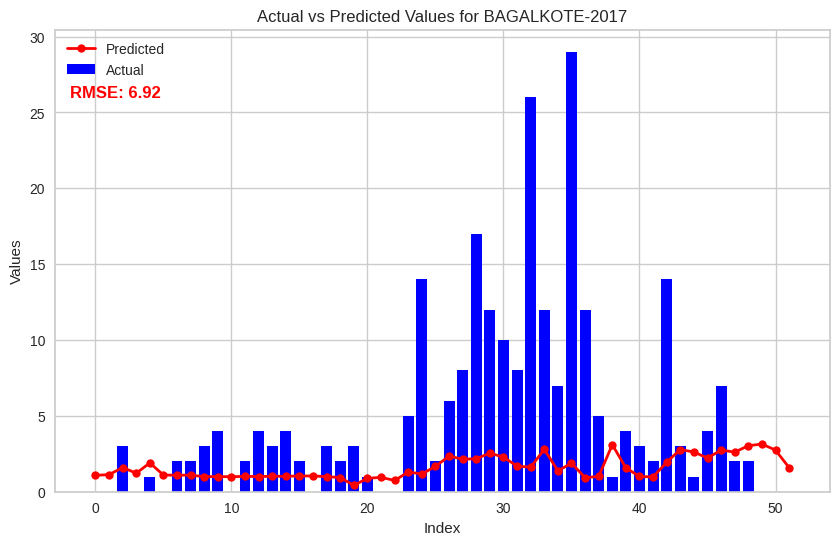

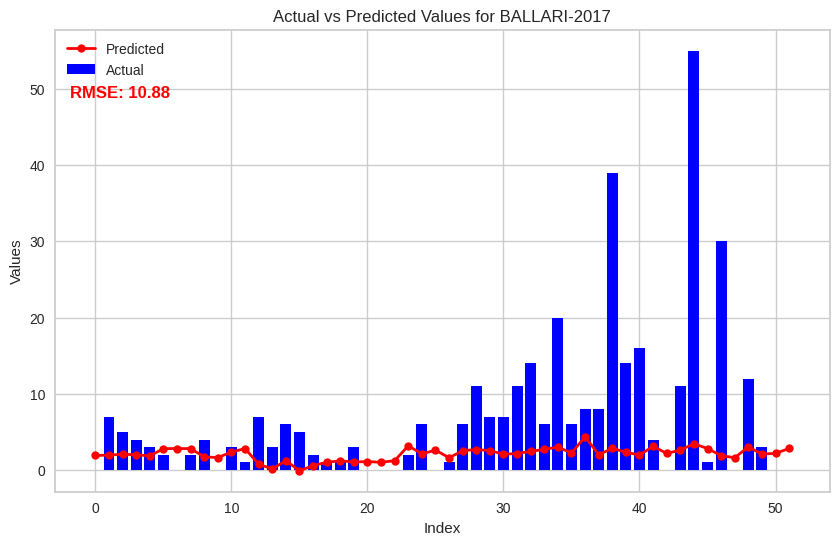

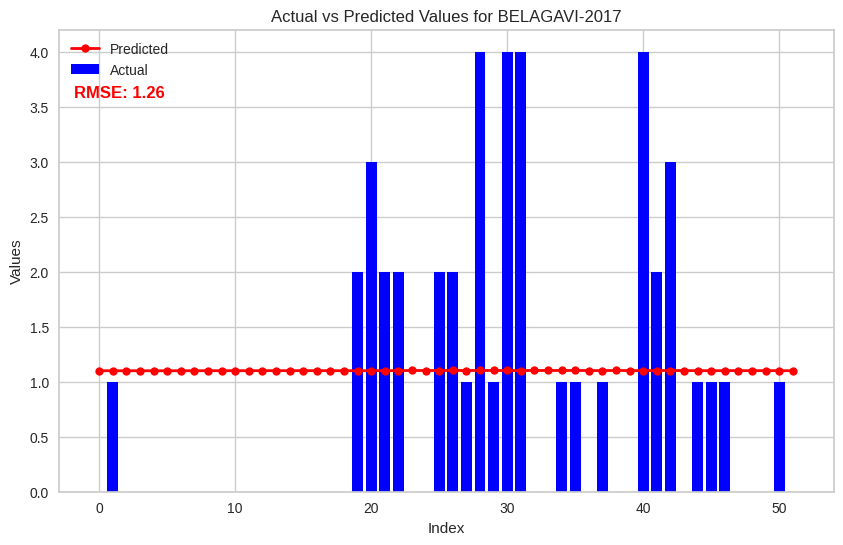

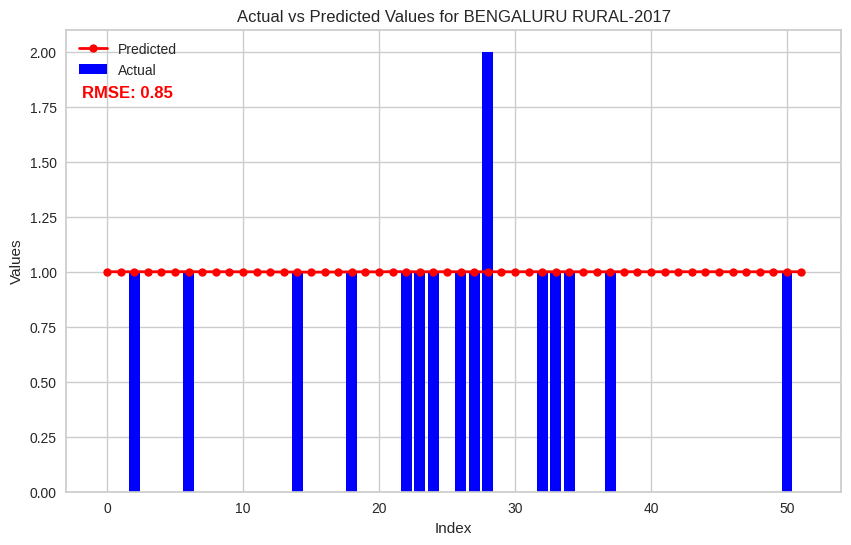

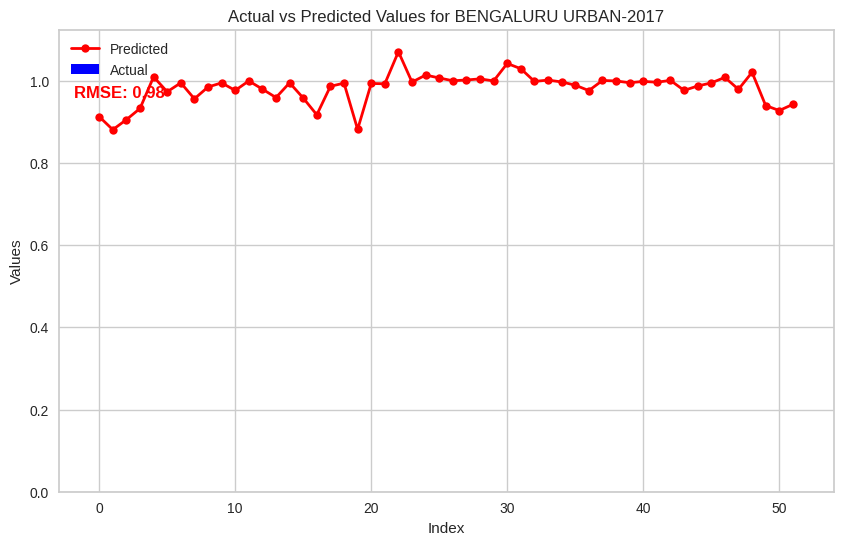

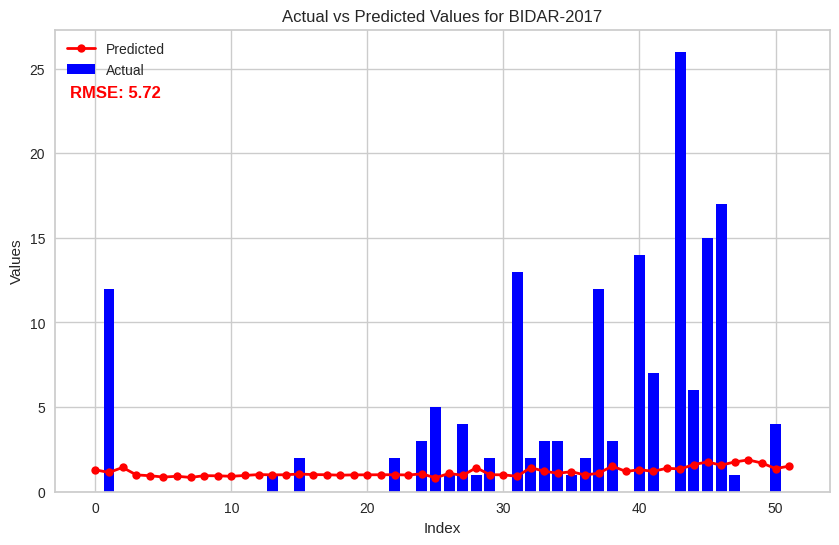

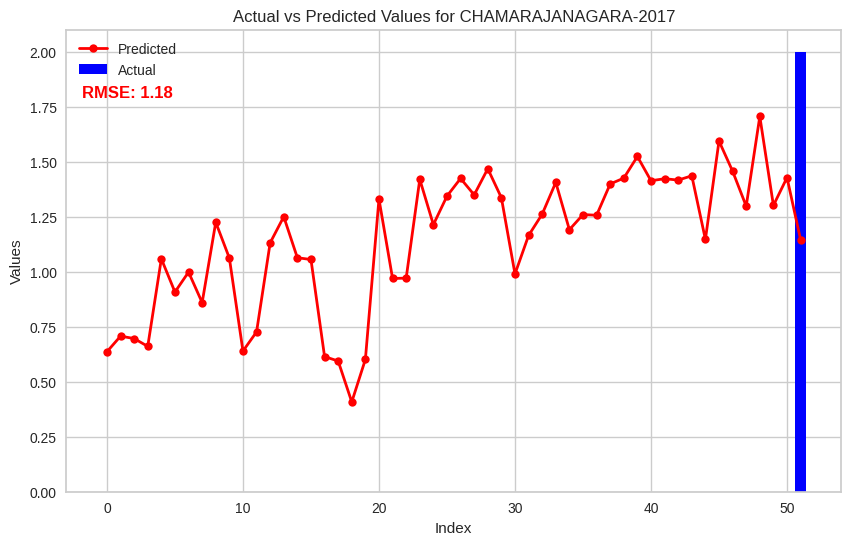

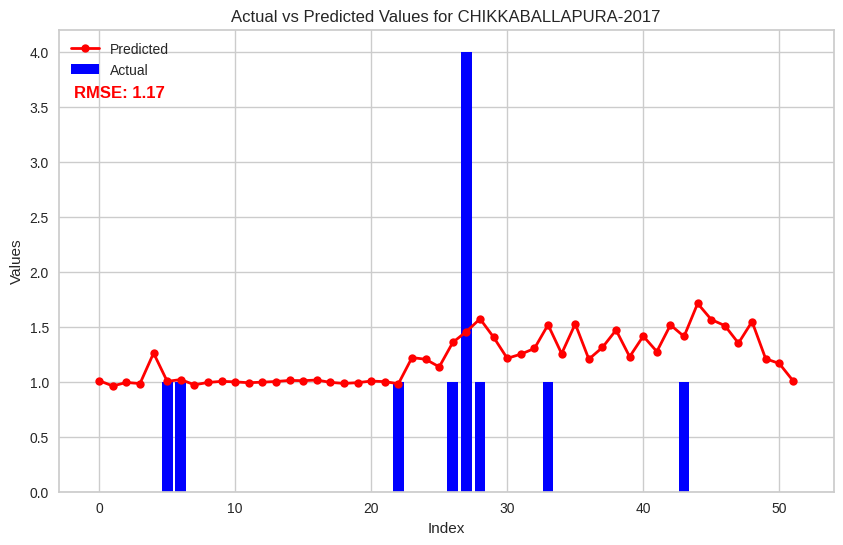

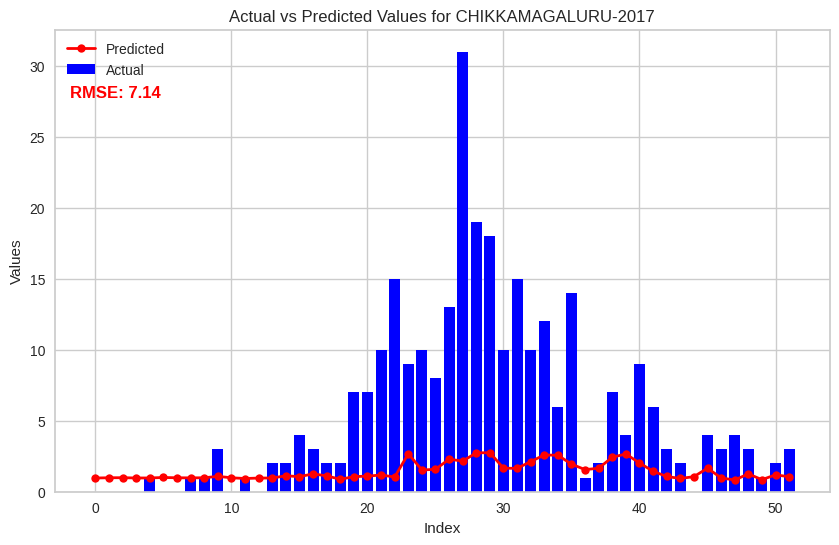

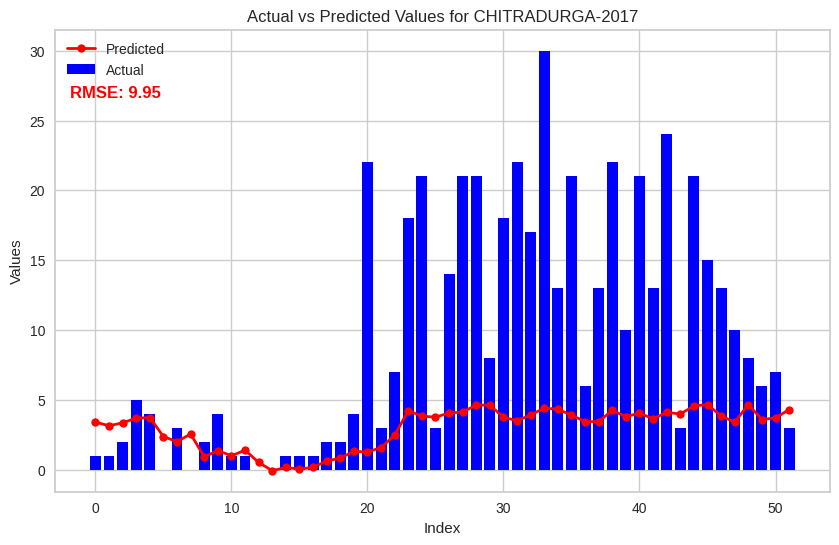

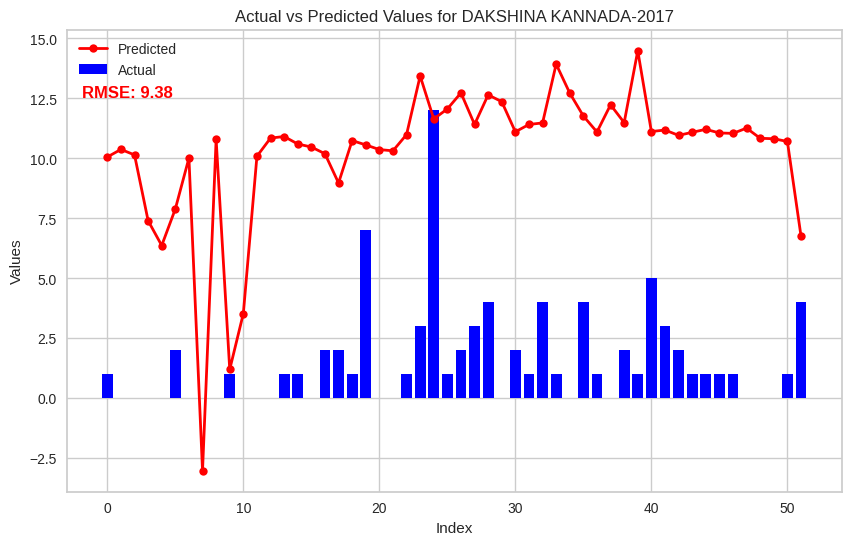

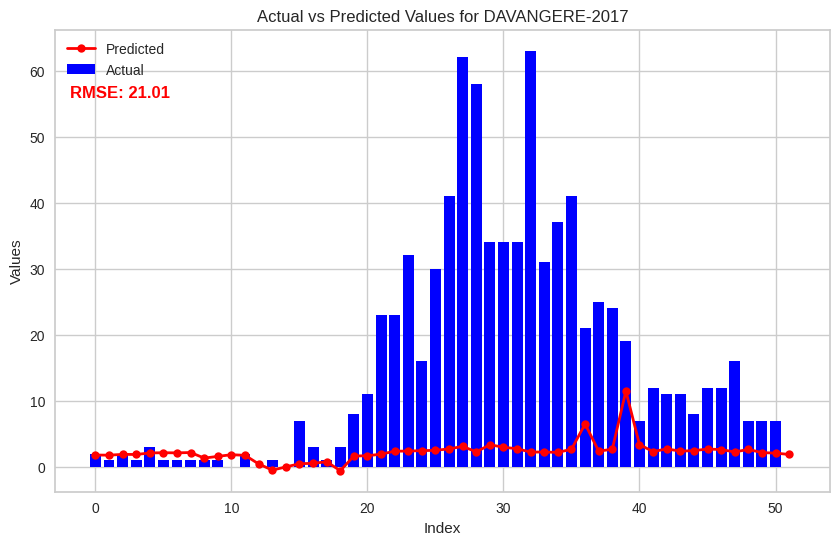

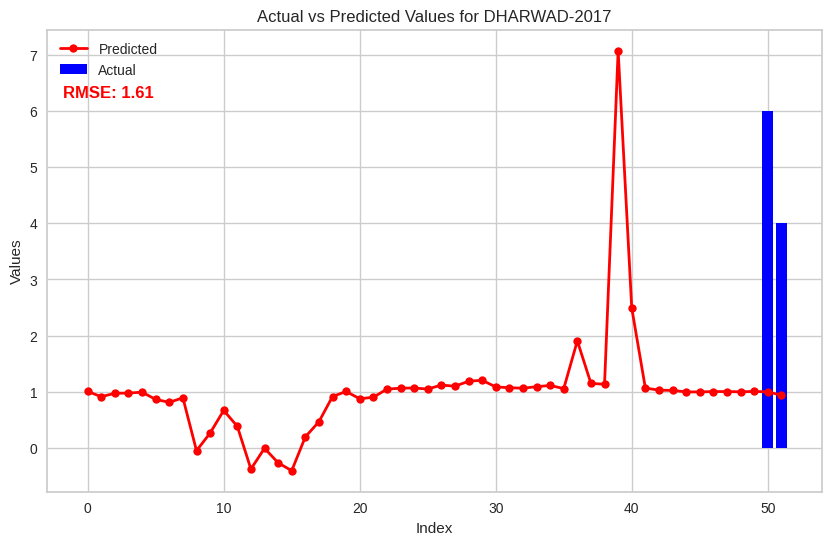

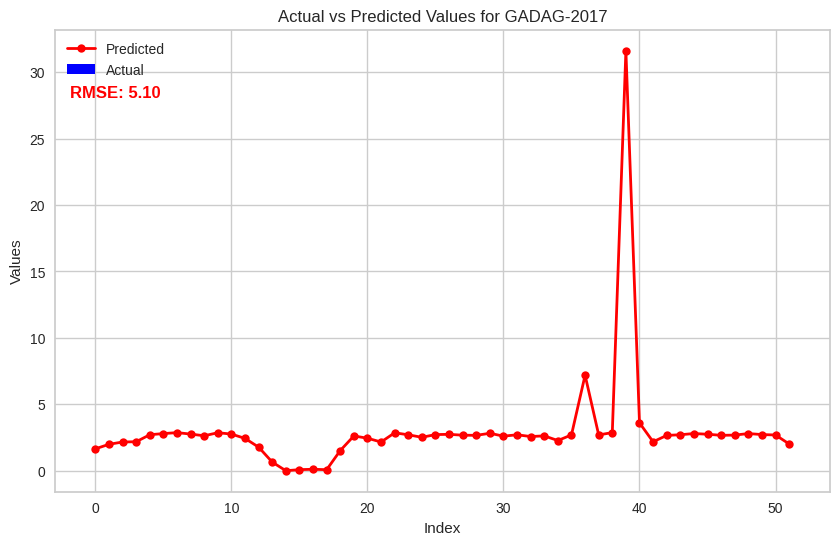

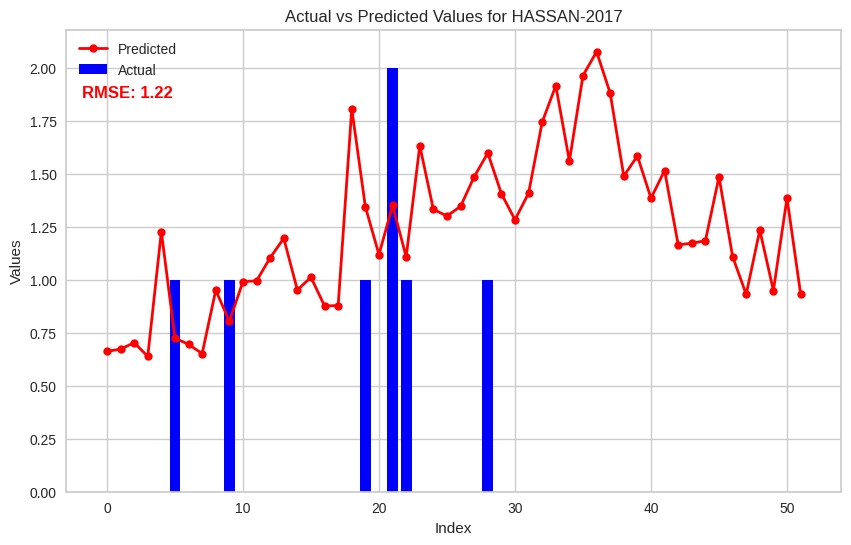

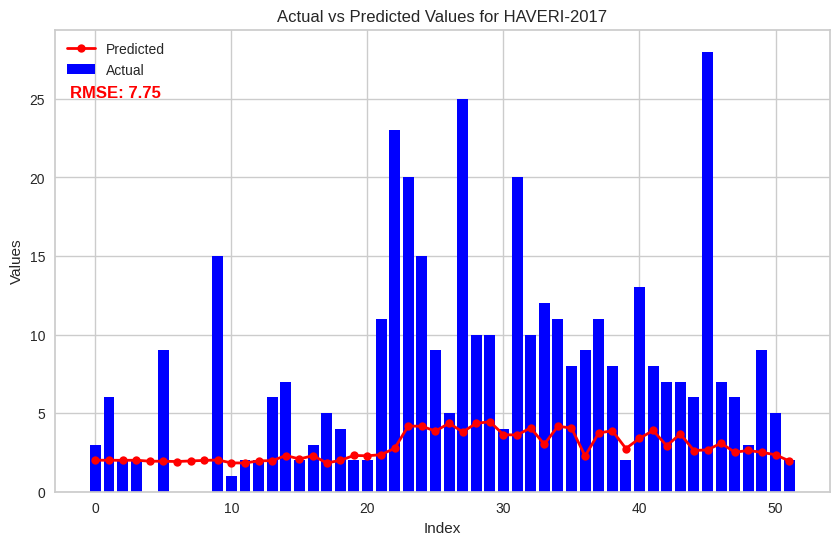

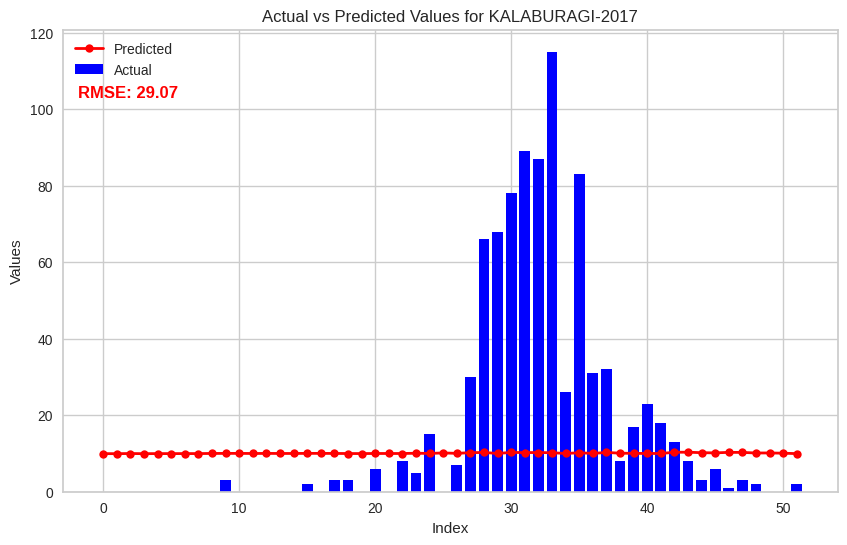

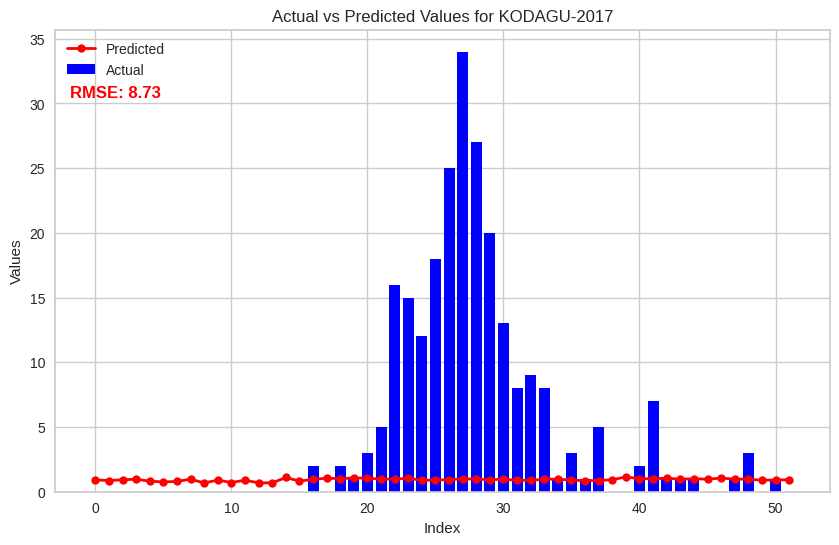

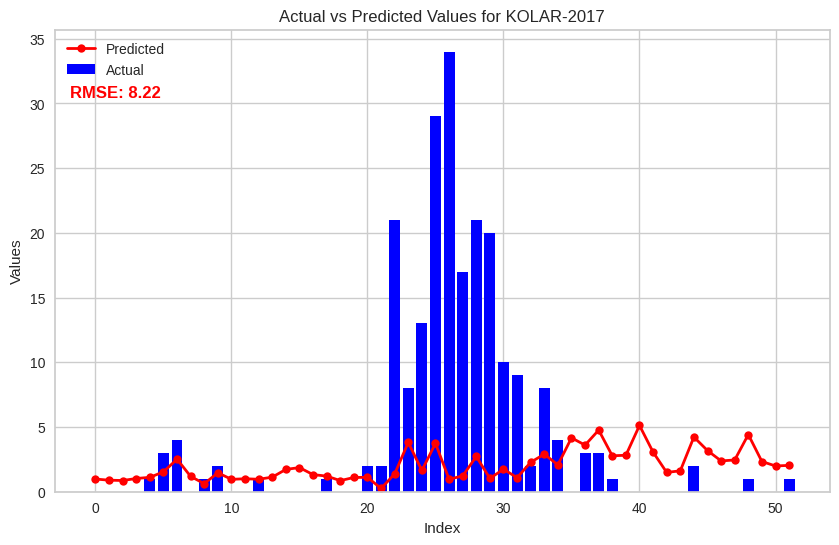

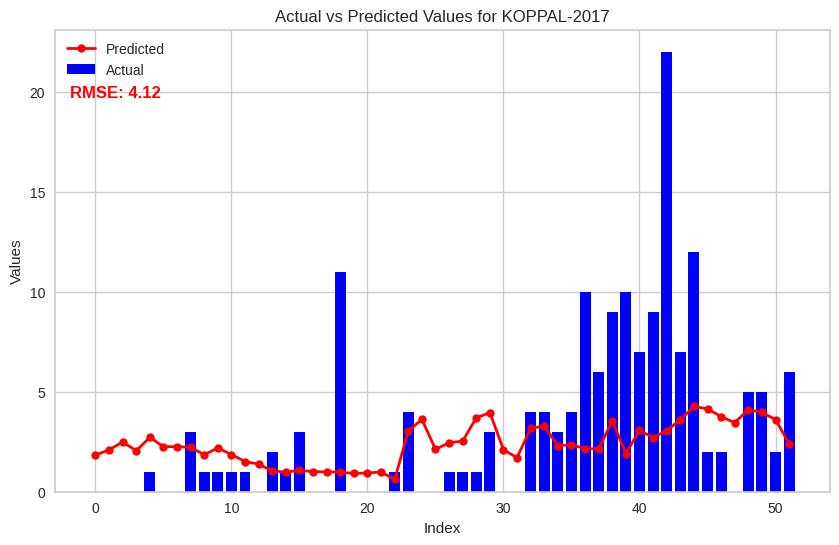

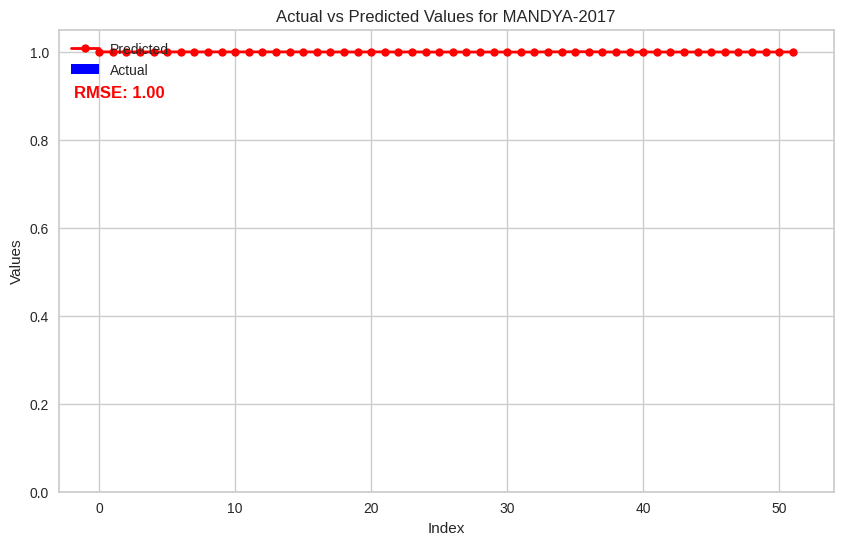

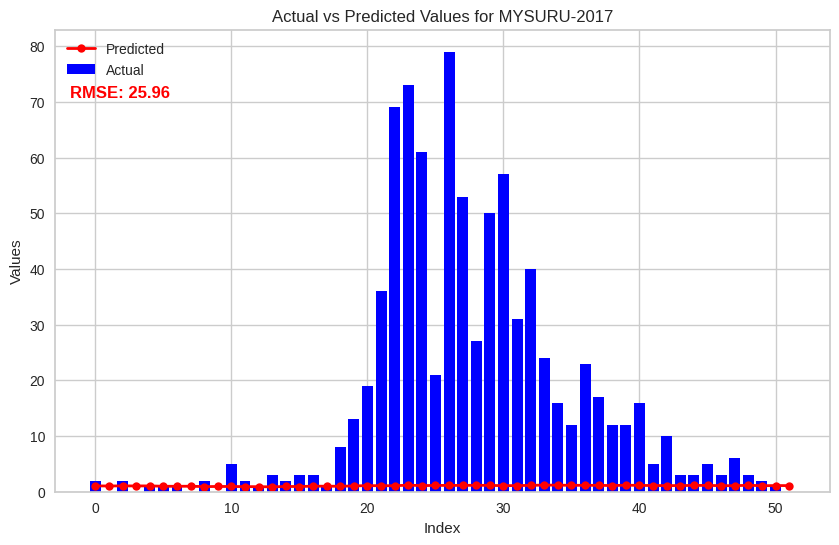

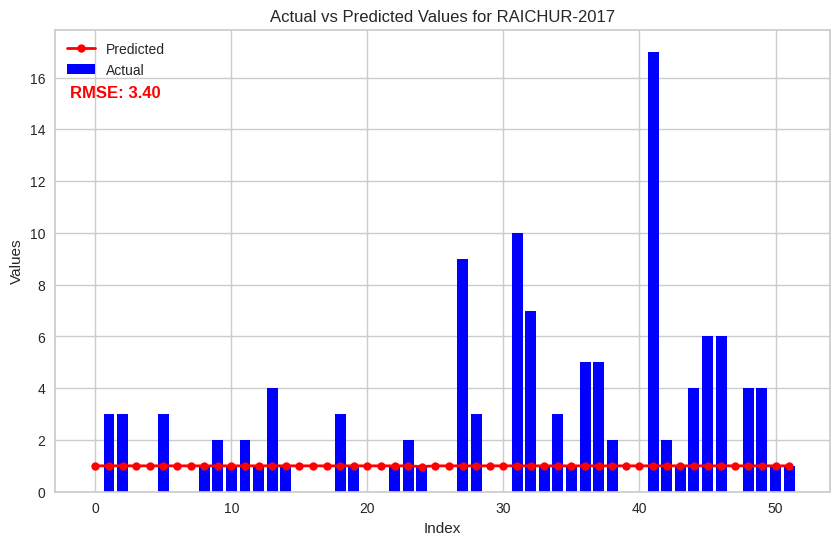

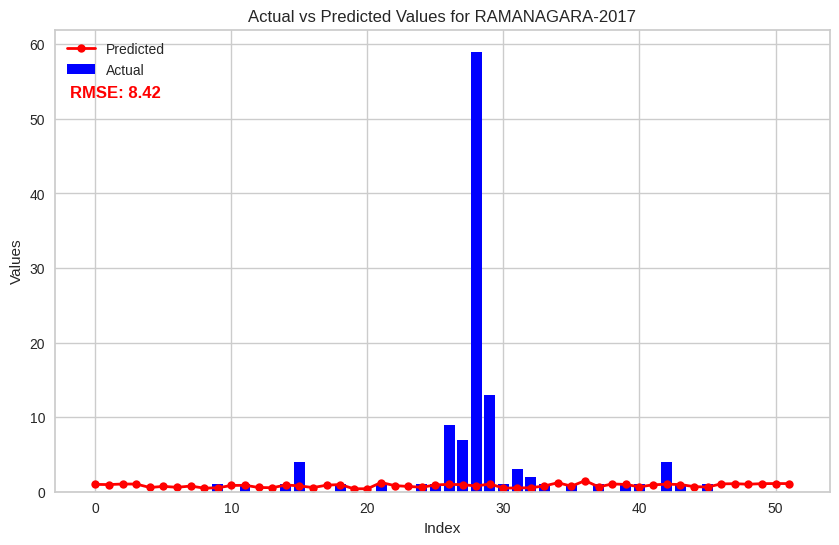

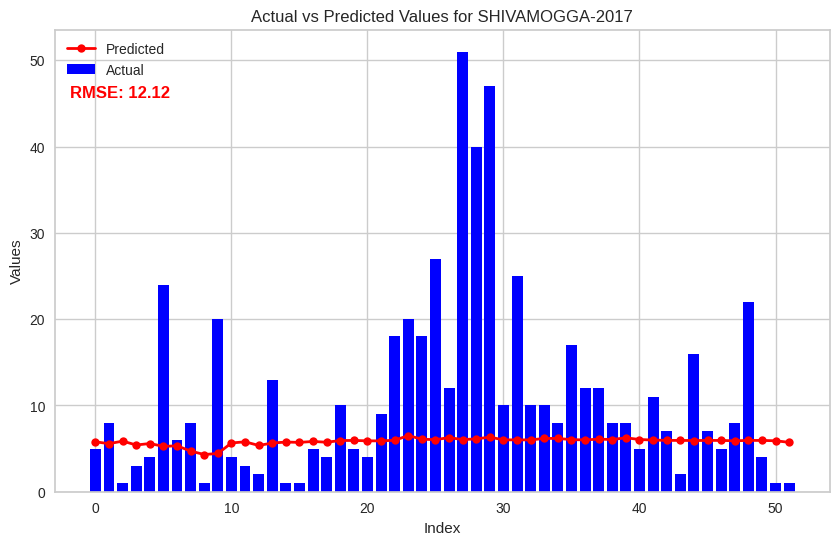

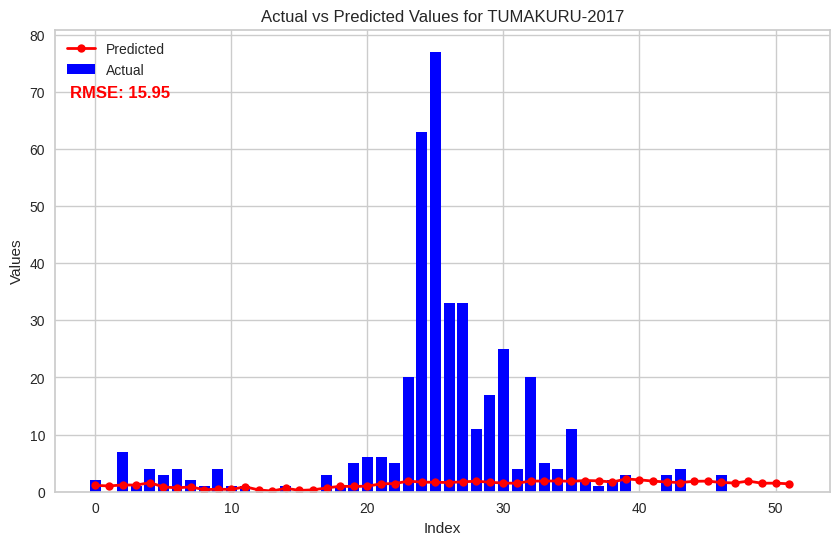

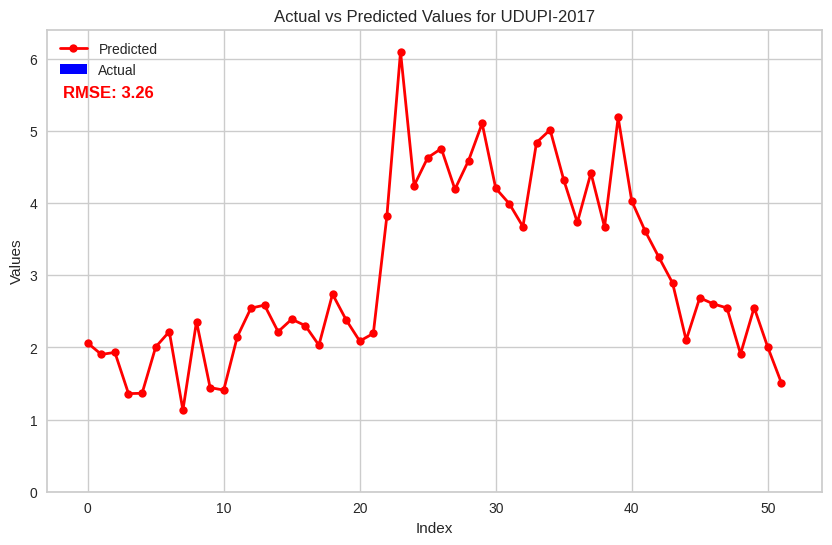

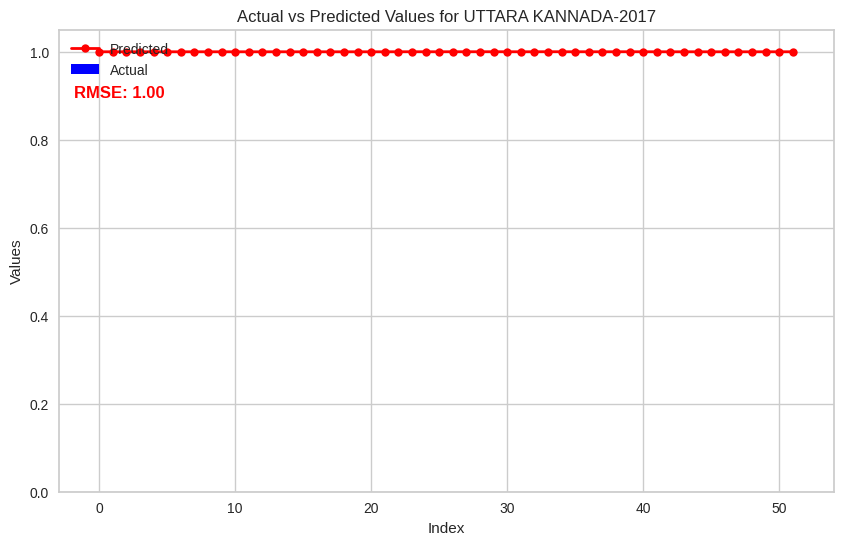

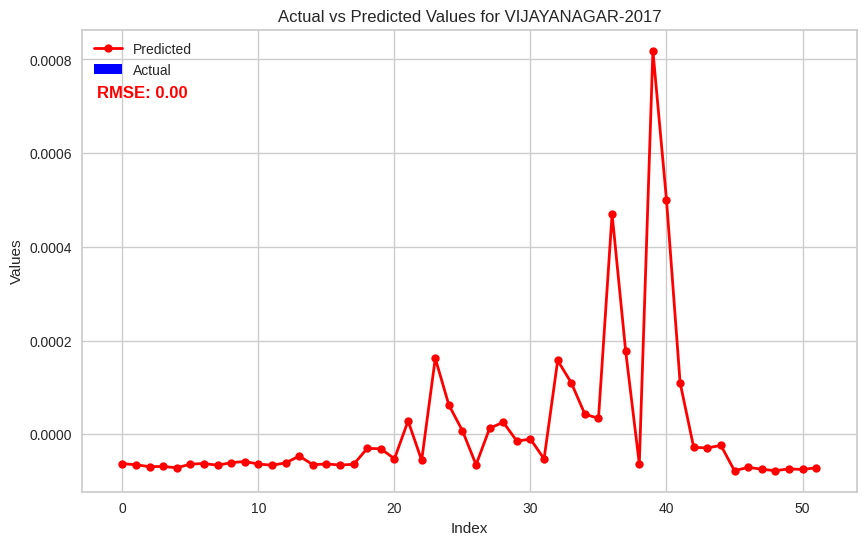

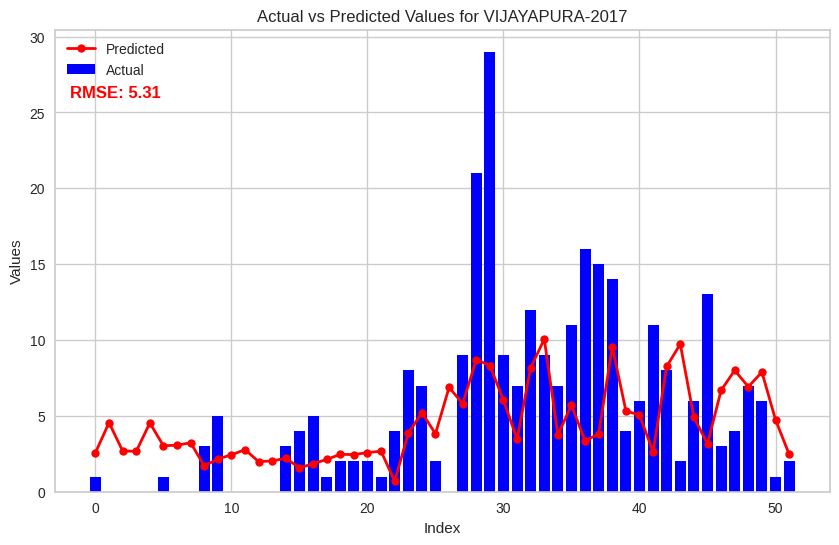

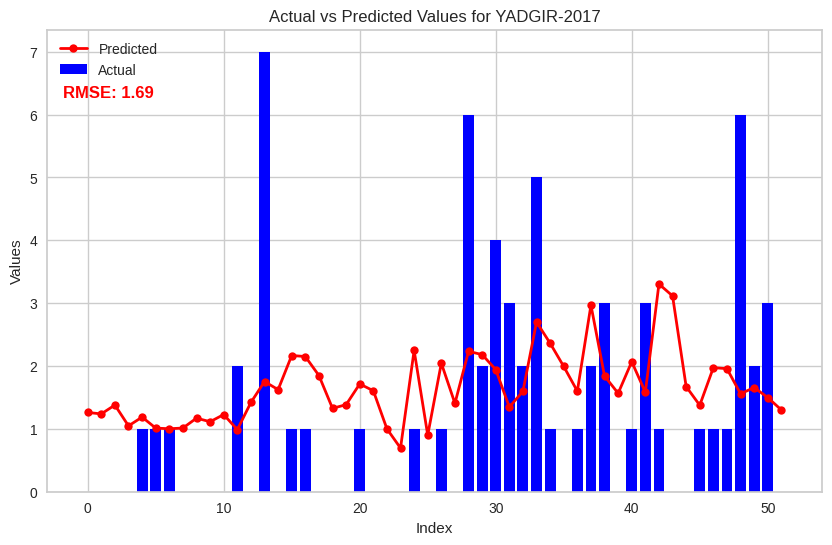

In [78]:
district_analysis = DistrictAnalysis("Karnataka_weather1980to2022.csv",2017)
df_2017 = district_analysis.analyze_districts()

In [79]:
df_2017

district  2017_rmse 2017_performance
0          BAGALKOTE   6.915504              Bad
1            BALLARI  10.880000              Bad
2           BELAGAVI   1.256539             Good
3    BENGALURU RURAL   0.854630             Good
4    BENGALURU URBAN   0.983121             Good
5              BIDAR   5.723328              Bad
6    CHAMARAJANAGARA   1.177380             Good
7    CHIKKABALLAPURA   1.169345             Good
8     CHIKKAMAGALURU   7.135522              Bad
9        CHITRADURGA   9.949612              Bad
10  DAKSHINA KANNADA   9.384641              Bad
11         DAVANGERE  21.011381              Bad
12           DHARWAD   1.608420             Good
13             GADAG   5.101642              Bad
14            HASSAN   1.223690             Good
15            HAVERI   7.751207              Bad
16        KALABURAGI  29.065948              Bad
17            KODAGU   8.726739              Bad
18             KOLAR   8.219229              Bad
19            KOPPAL   4.122887              Bad
20            MANDYA   1.000033             Good
21            MYSURU  25.964426              Bad
22           RAICHUR   3.399759              Bad
23        RAMANAGARA   8.418929              Bad
24        SHIVAMOGGA  12.121652              Bad
25          TUMAKURU  15.948241              Bad
26             UDUPI   3.258533              Bad
27    UTTARA KANNADA   0.999997             Good
28       VIJAYANAGAR   0.000164             Good
29        VIJAYAPURA   5.306299              Bad
30            YADGIR   1.690699             Good

Analyzing District: BAGALKOTE
Analyzing District: BALLARI
Analyzing District: BELAGAVI
Analyzing District: BENGALURU RURAL
Analyzing District: BENGALURU URBAN
Analyzing District: BIDAR
Analyzing District: CHAMARAJANAGARA
Analyzing District: CHIKKABALLAPURA
Analyzing District: CHIKKAMAGALURU
Analyzing District: CHITRADURGA
Analyzing District: DAKSHINA KANNADA
Analyzing District: DAVANGERE
Analyzing District: DHARWAD
Analyzing District: GADAG
Analyzing District: HASSAN
Analyzing District: HAVERI
Analyzing District: KALABURAGI
Analyzing District: KODAGU
Analyzing District: KOLAR
Analyzing District: KOPPAL
Analyzing District: MANDYA
Analyzing District: MYSURU
Analyzing District: RAICHUR
Analyzing District: RAMANAGARA
Analyzing District: SHIVAMOGGA
Analyzing District: TUMAKURU
Analyzing District: UDUPI
Analyzing District: UTTARA KANNADA
Analyzing District: VIJAYANAGAR
Analyzing District: VIJAYAPURA
Analyzing District: YADGIR


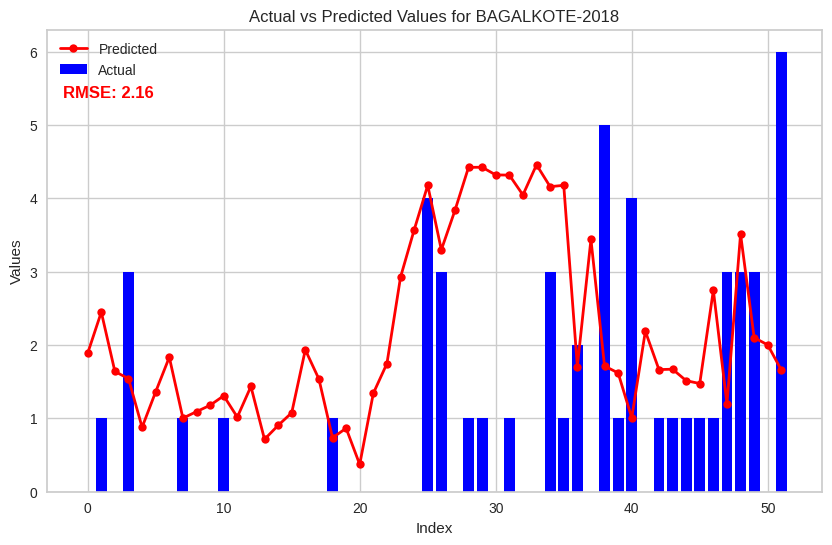

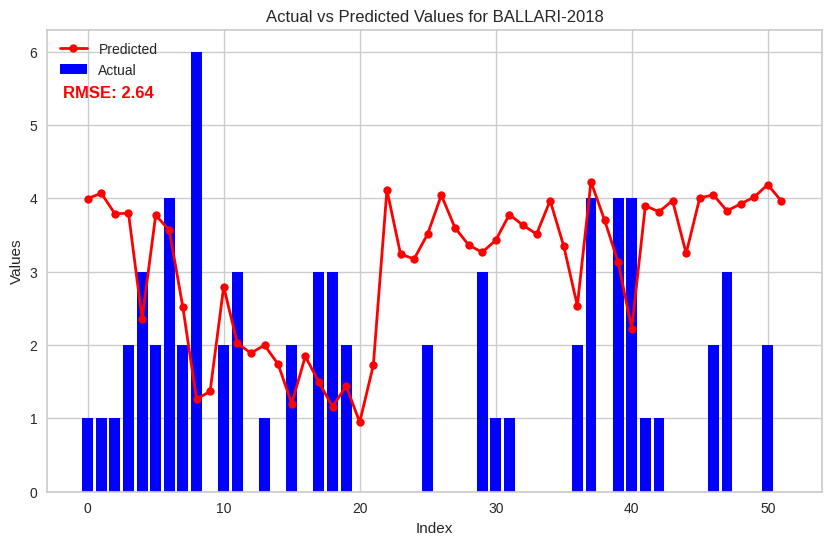

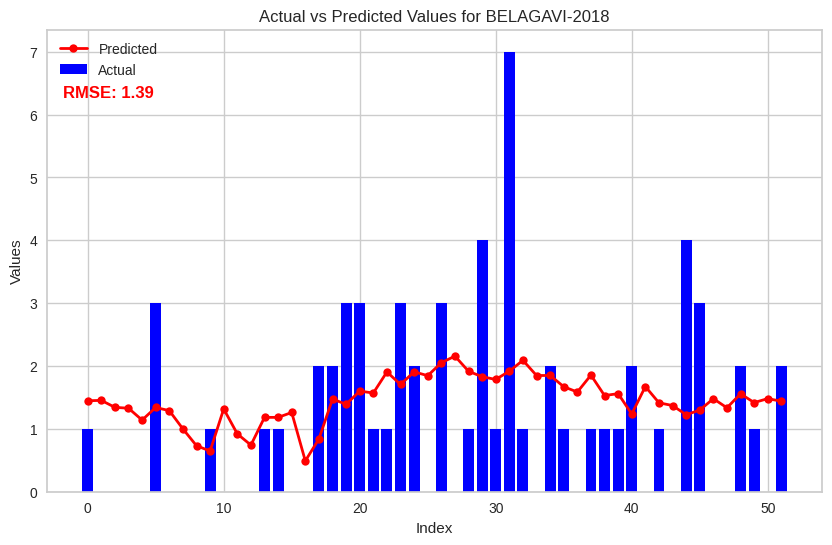

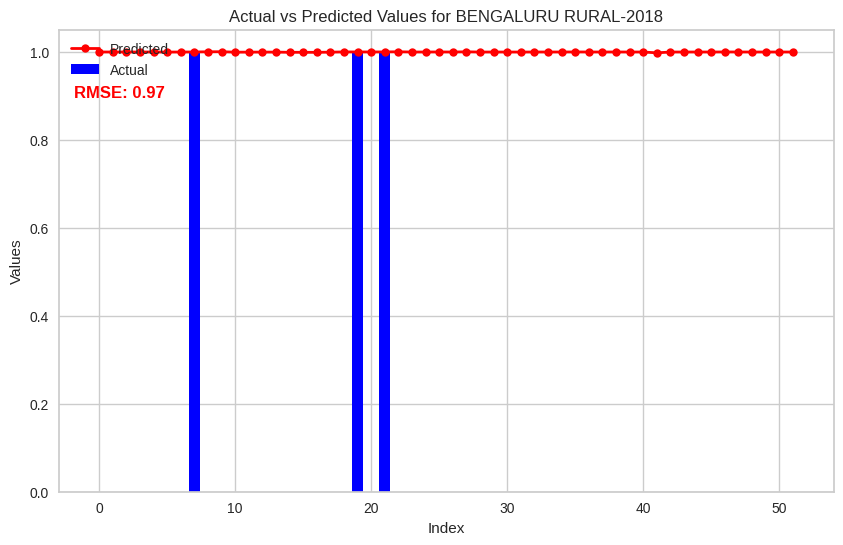

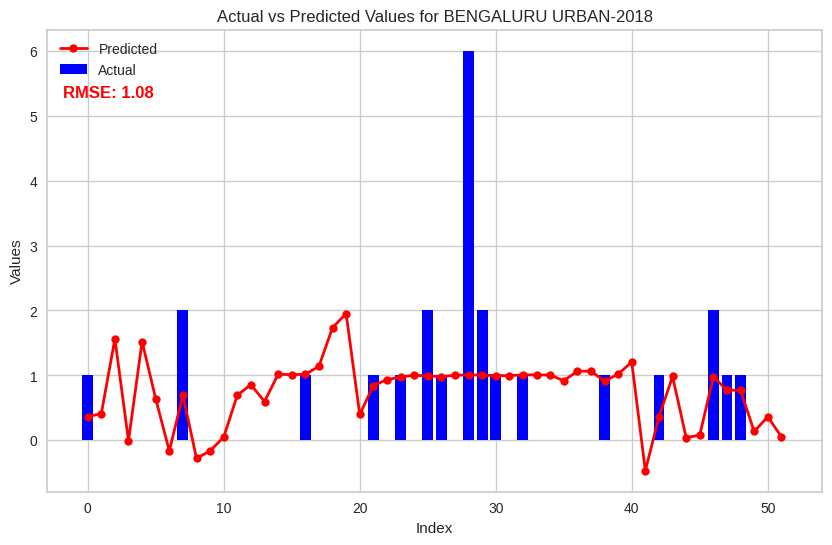

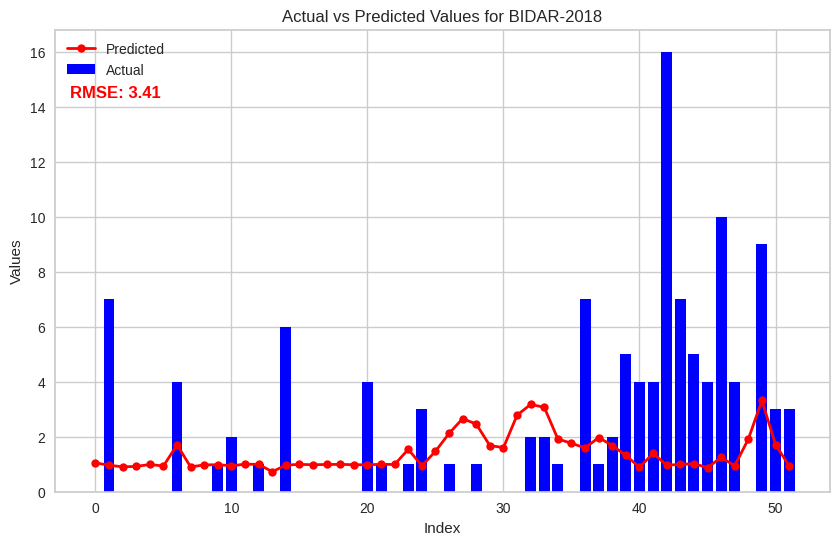

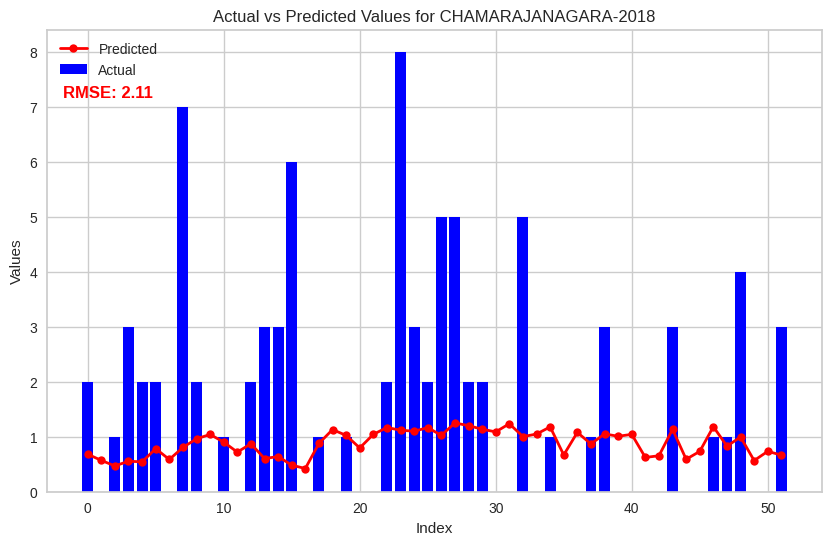

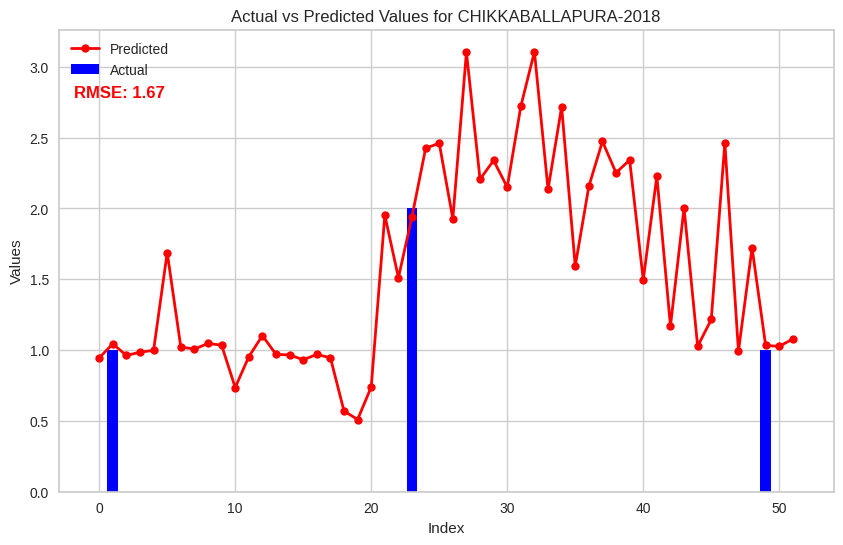

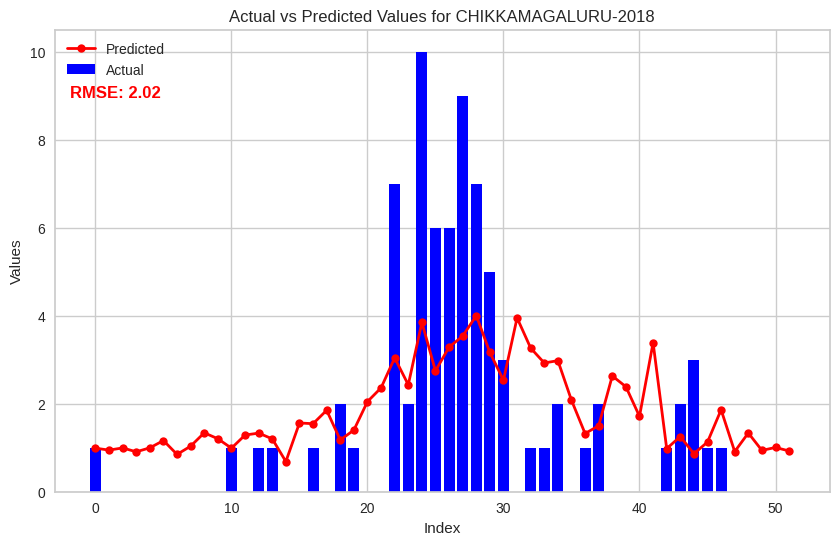

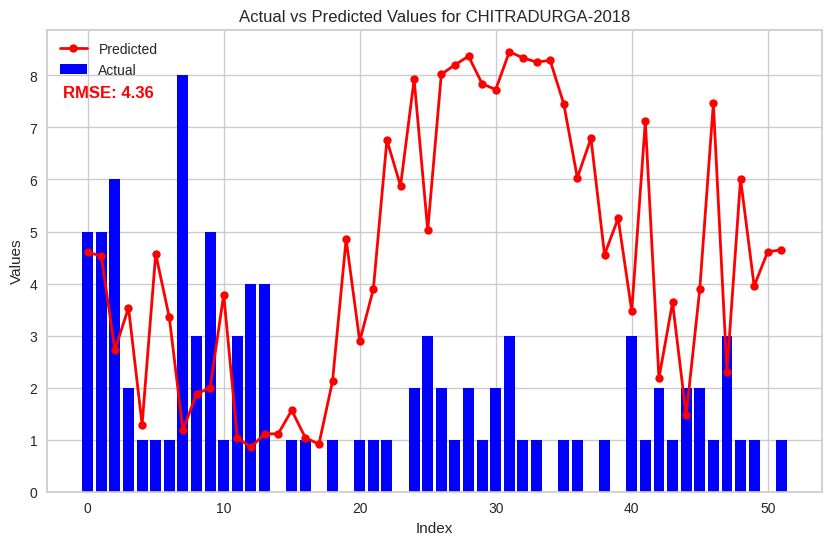

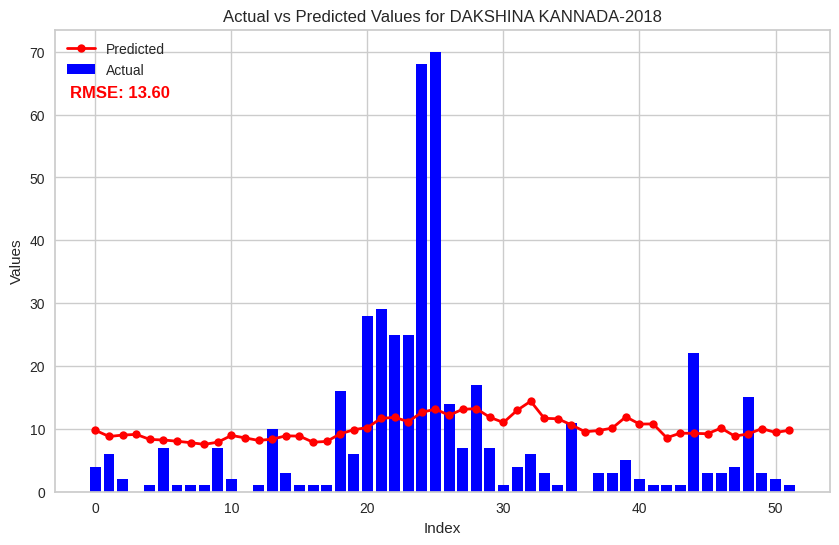

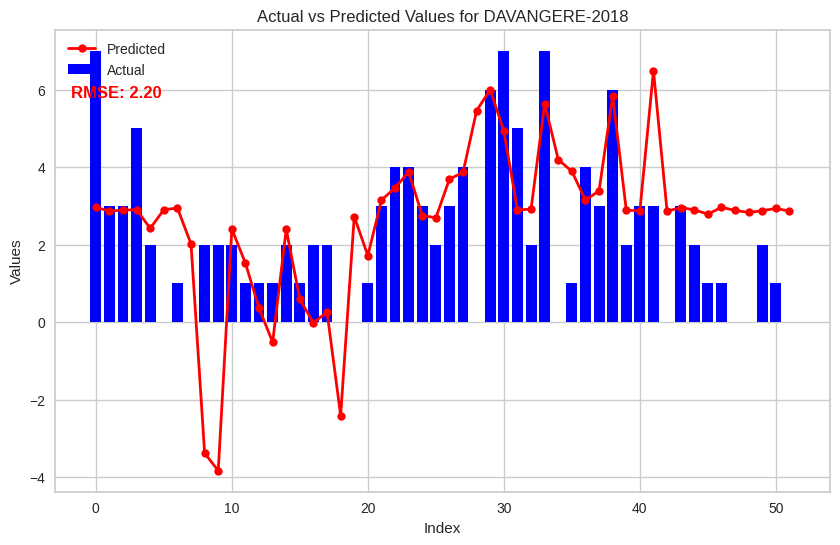

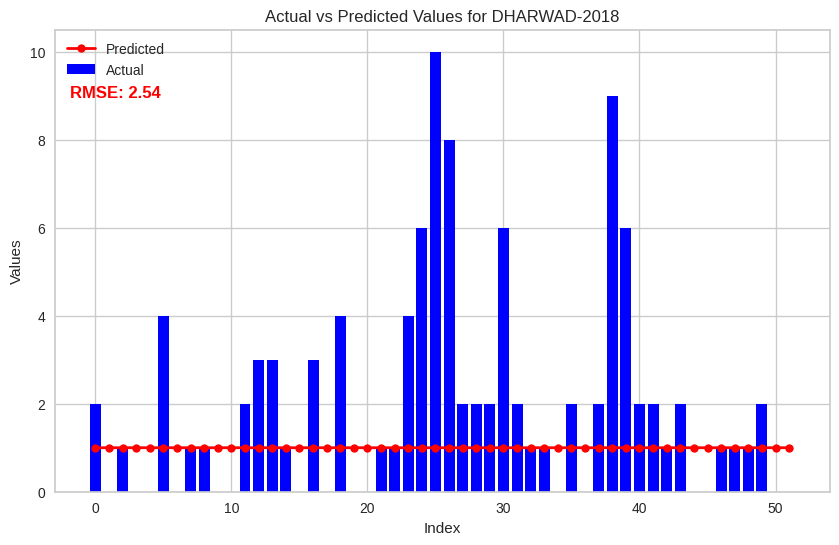

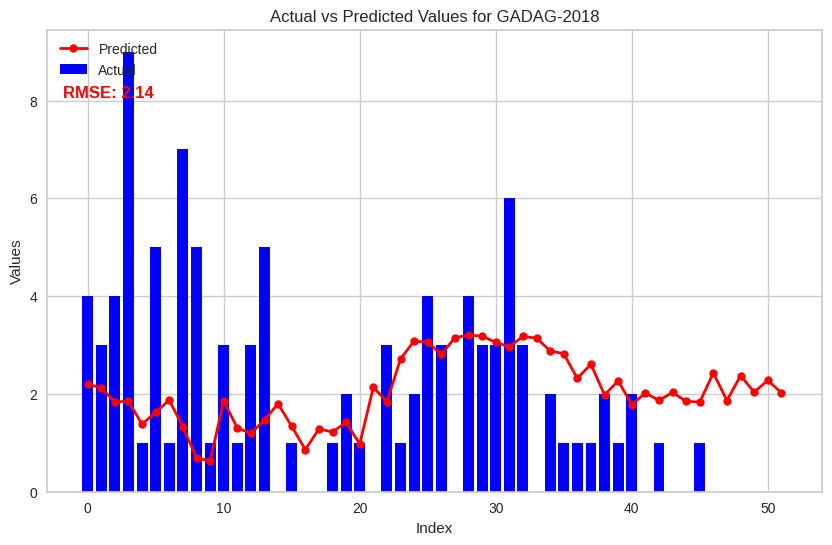

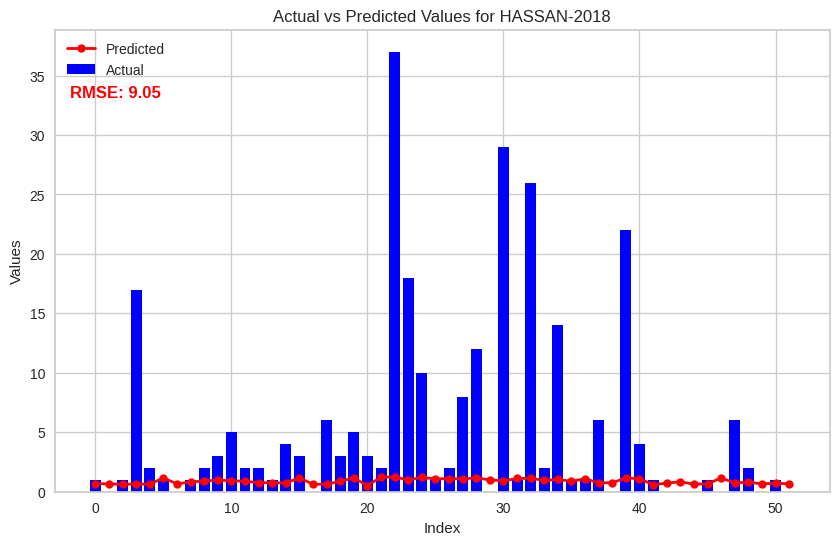

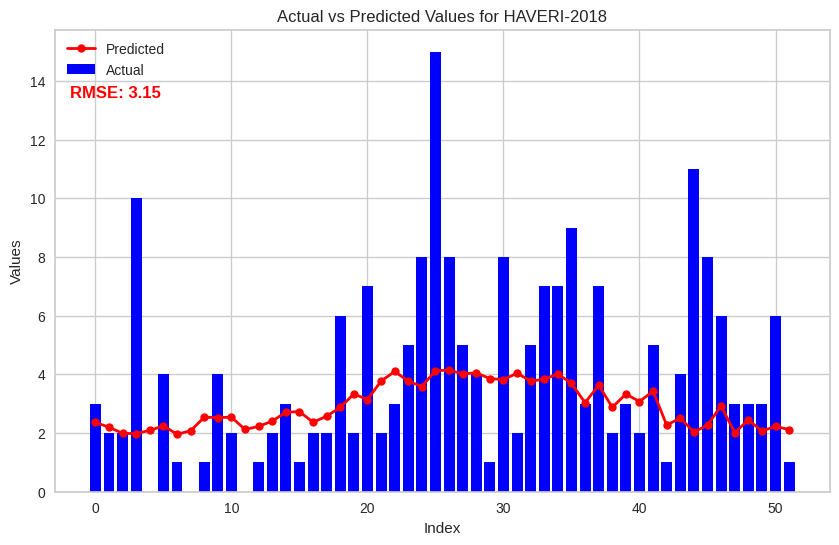

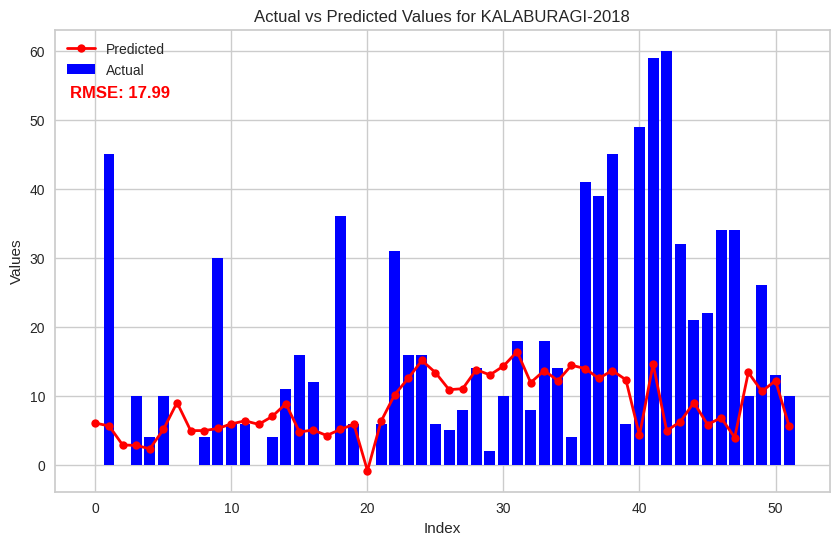

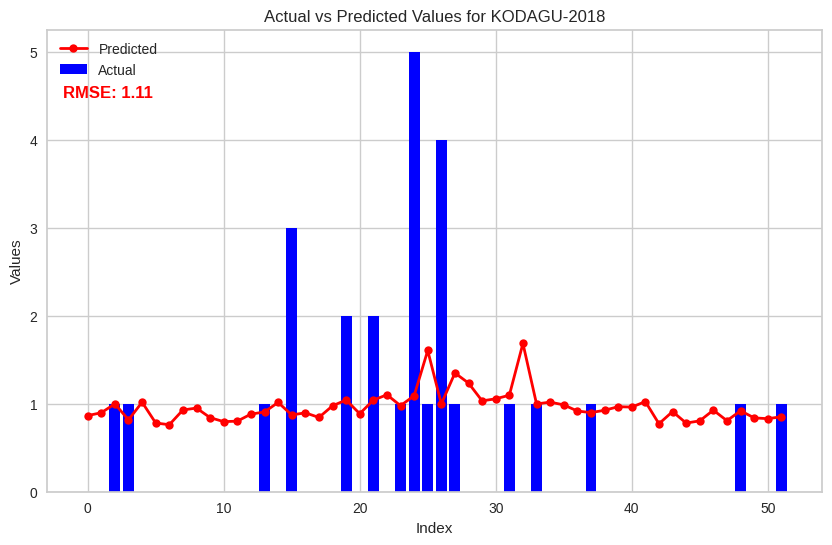

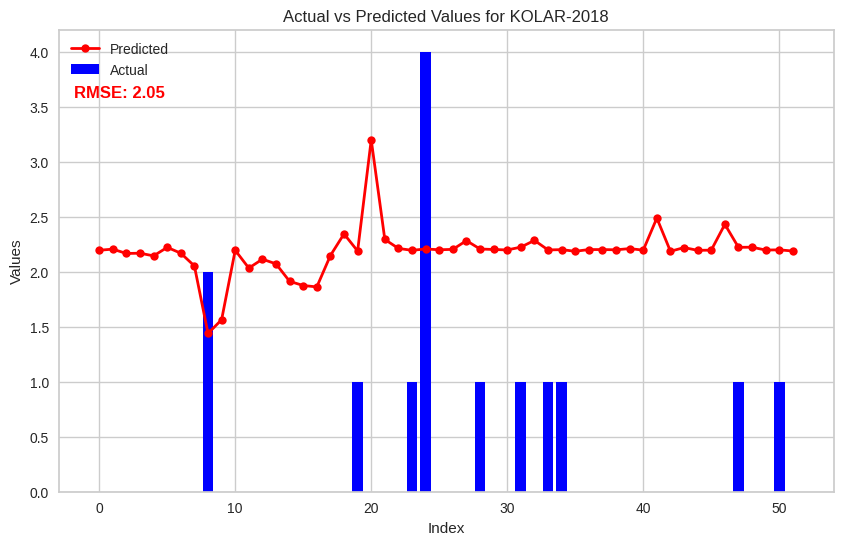

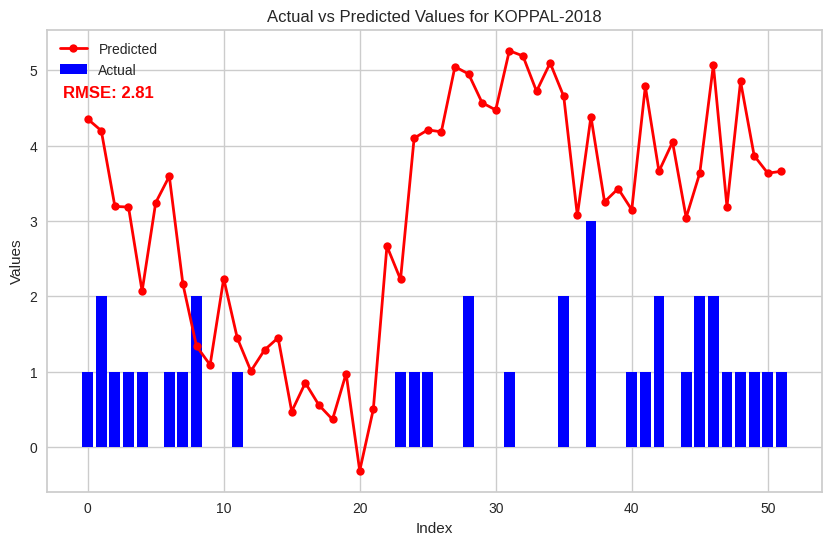

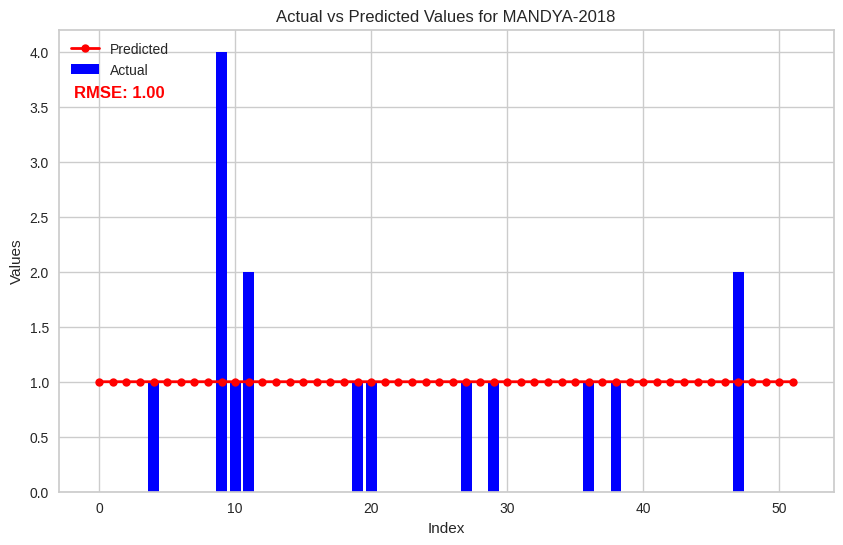

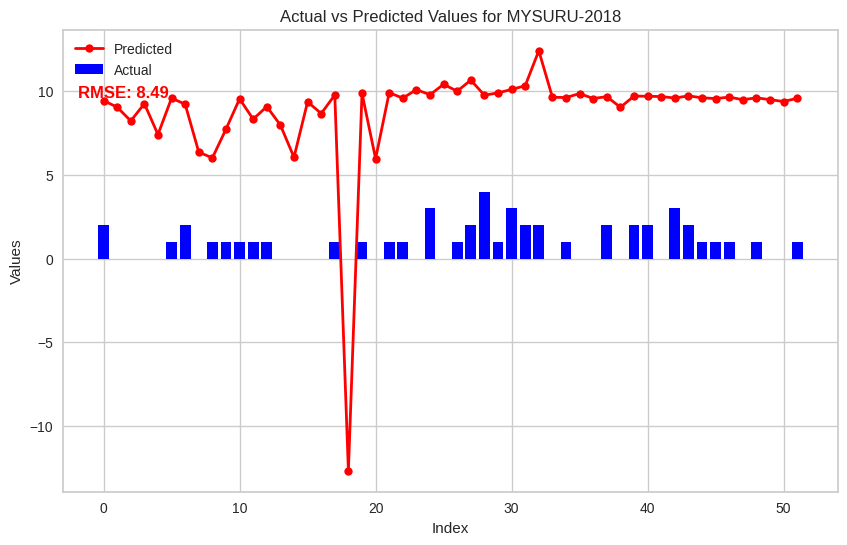

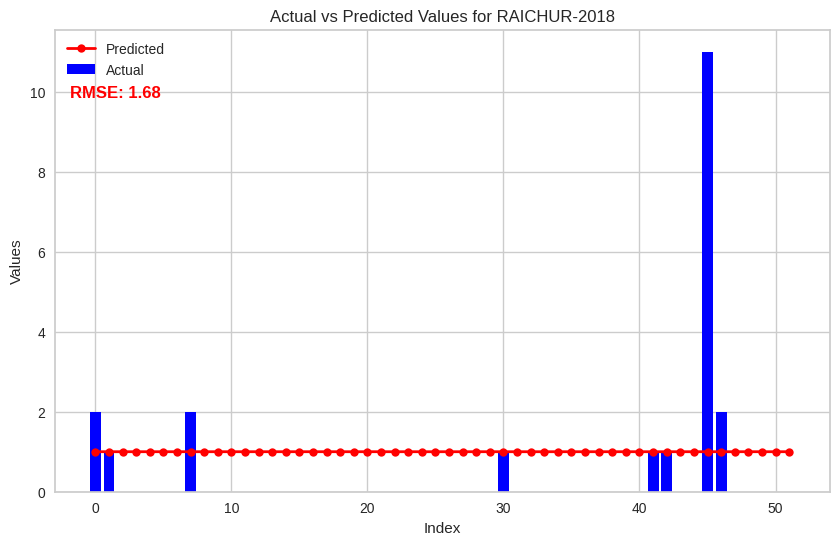

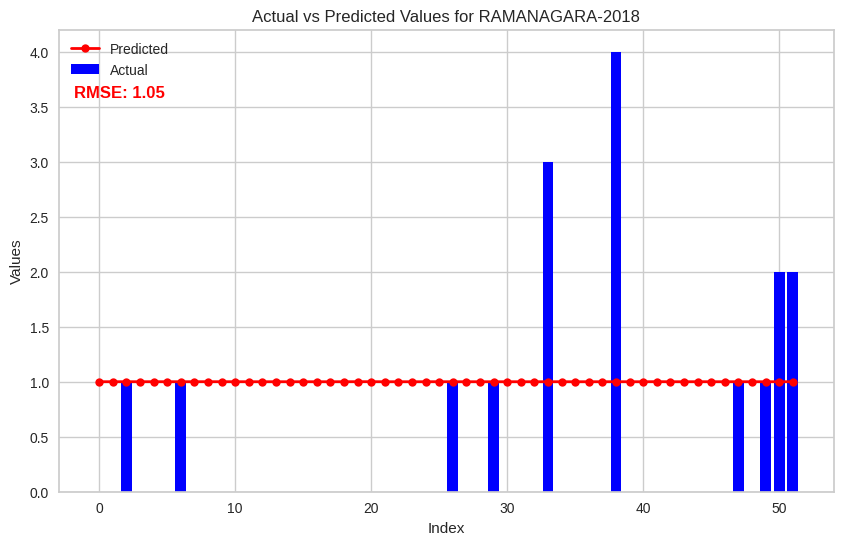

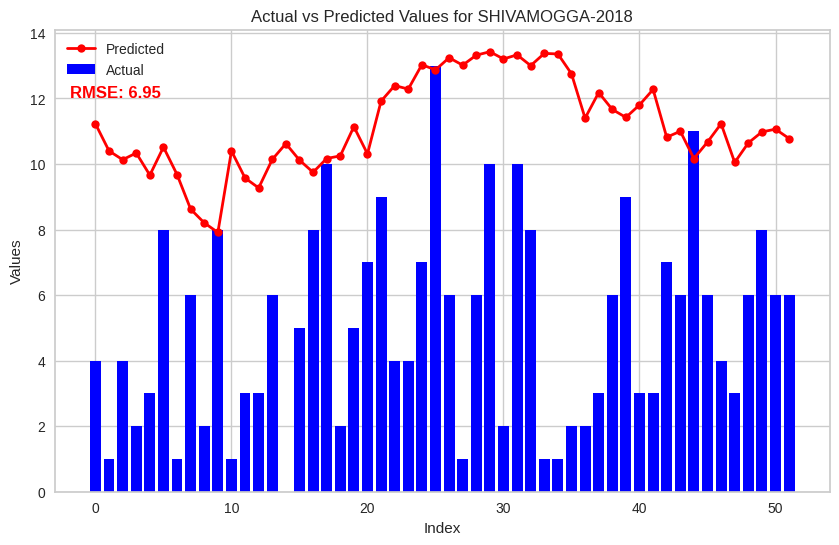

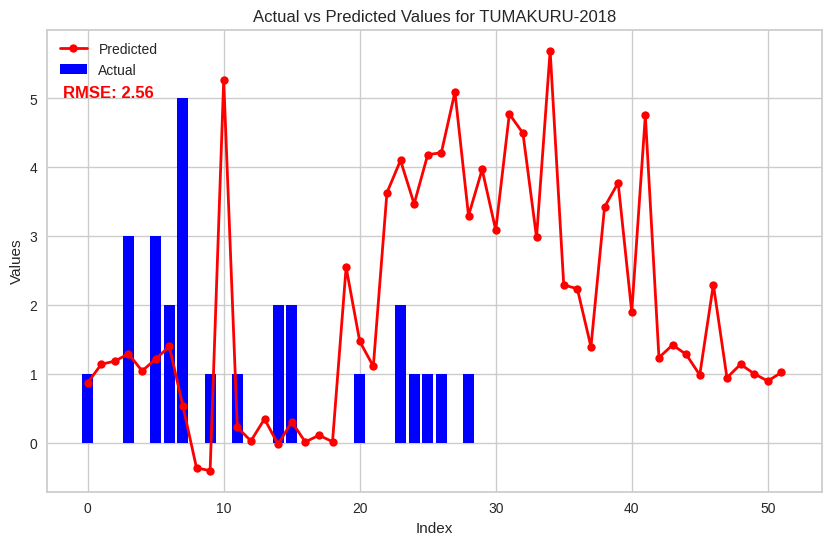

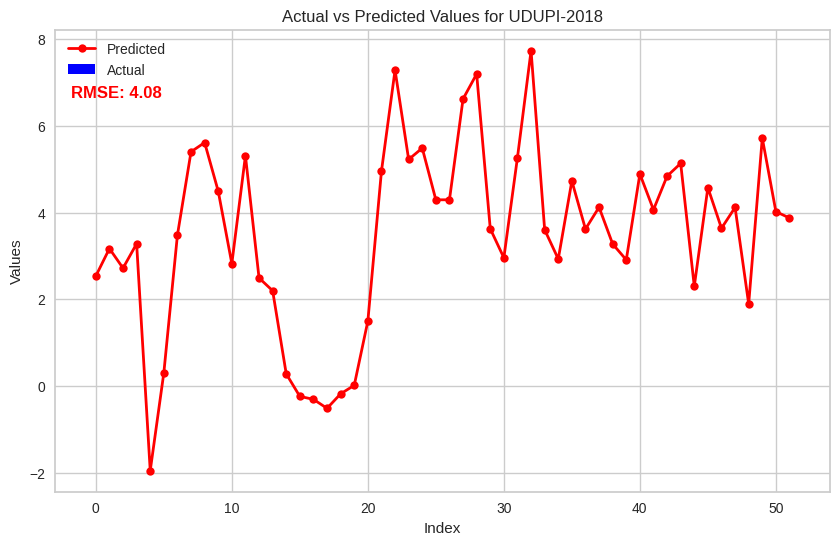

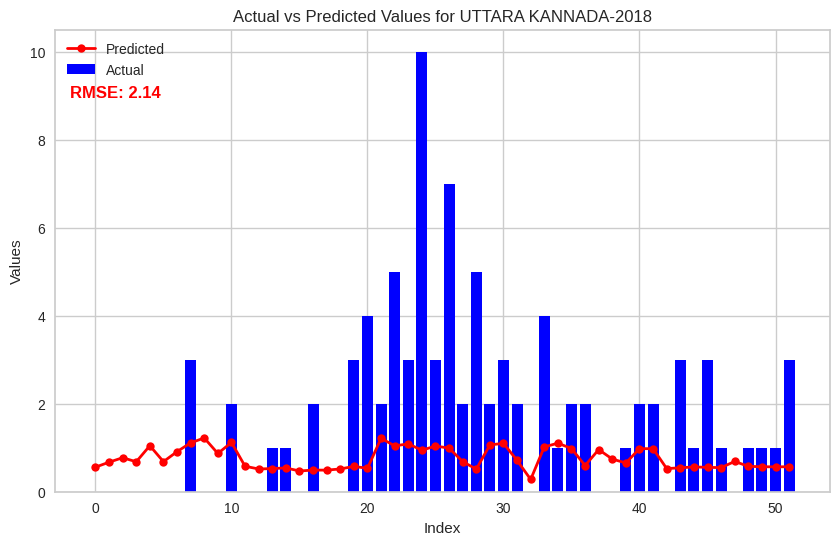

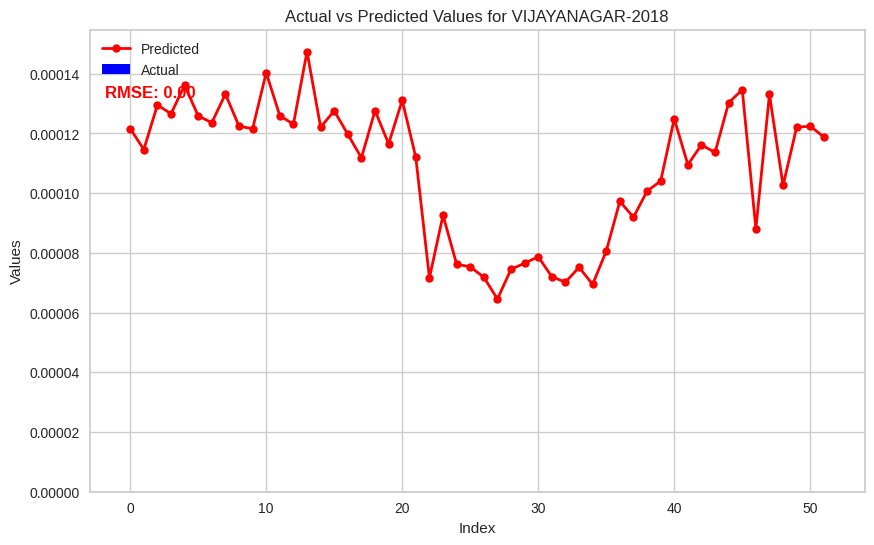

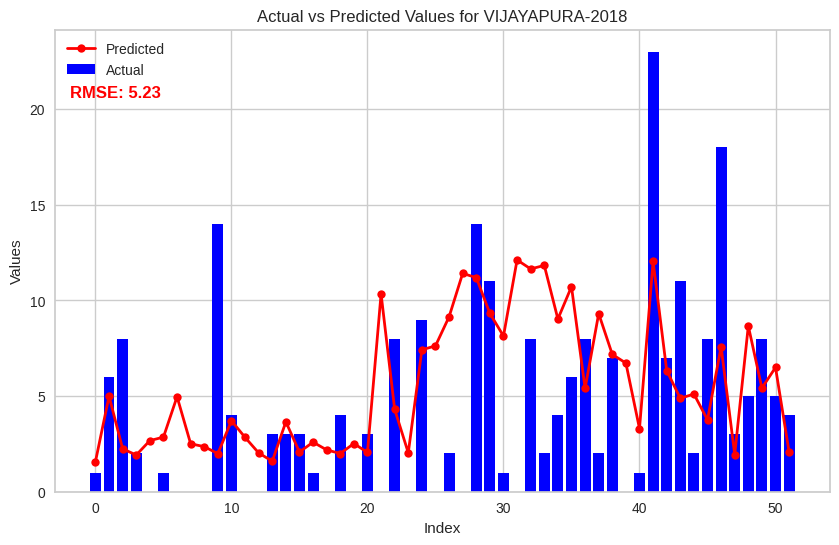

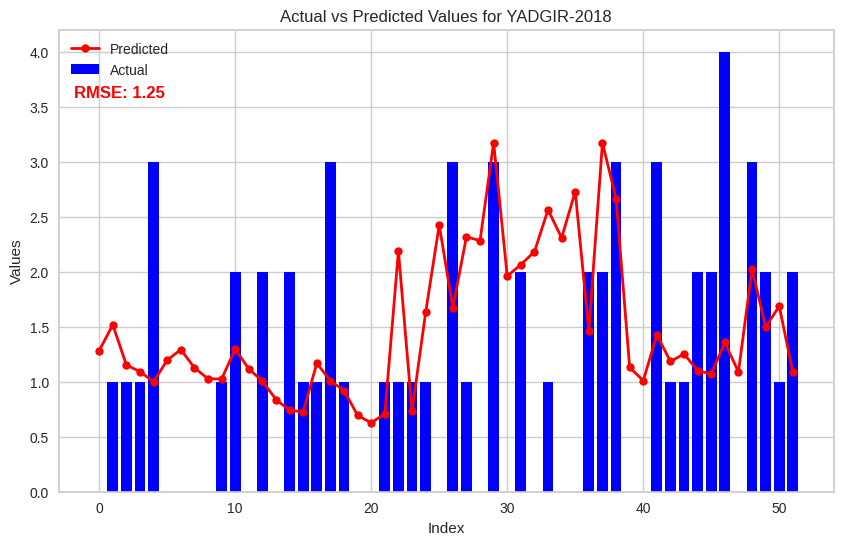

In [80]:
district_analysis = DistrictAnalysis("Karnataka_weather1980to2022.csv",2018)
df_2018 = district_analysis.analyze_districts()

In [81]:
df_2018

district  2018_rmse 2018_performance
0          BAGALKOTE   2.157593              Bad
1            BALLARI   2.635411              Bad
2           BELAGAVI   1.387086             Good
3    BENGALURU RURAL   0.970509             Good
4    BENGALURU URBAN   1.081871             Good
5              BIDAR   3.406929              Bad
6    CHAMARAJANAGARA   2.108141              Bad
7    CHIKKABALLAPURA   1.674109             Good
8     CHIKKAMAGALURU   2.016957              Bad
9        CHITRADURGA   4.363978              Bad
10  DAKSHINA KANNADA  13.600531              Bad
11         DAVANGERE   2.200556              Bad
12           DHARWAD   2.541935              Bad
13             GADAG   2.141566              Bad
14            HASSAN   9.049327              Bad
15            HAVERI   3.150555              Bad
16        KALABURAGI  17.992814              Bad
17            KODAGU   1.107638             Good
18             KOLAR   2.051030              Bad
19            KOPPAL   2.810984              Bad
20            MANDYA   0.999999             Good
21            MYSURU   8.494255              Bad
22           RAICHUR   1.681381             Good
23        RAMANAGARA   1.047003             Good
24        SHIVAMOGGA   6.951225              Bad
25          TUMAKURU   2.563135              Bad
26             UDUPI   4.083122              Bad
27    UTTARA KANNADA   2.139263              Bad
28       VIJAYANAGAR   0.000111             Good
29        VIJAYAPURA   5.234098              Bad
30            YADGIR   1.246212             Good

Analyzing District: BAGALKOTE
Analyzing District: BALLARI
Analyzing District: BELAGAVI
Analyzing District: BENGALURU RURAL
Analyzing District: BENGALURU URBAN
Analyzing District: BIDAR
Analyzing District: CHAMARAJANAGARA
Analyzing District: CHIKKABALLAPURA
Analyzing District: CHIKKAMAGALURU
Analyzing District: CHITRADURGA
Analyzing District: DAKSHINA KANNADA
Analyzing District: DAVANGERE
Analyzing District: DHARWAD
Analyzing District: GADAG
Analyzing District: HASSAN
Analyzing District: HAVERI
Analyzing District: KALABURAGI
Analyzing District: KODAGU
Analyzing District: KOLAR
Analyzing District: KOPPAL
Analyzing District: MANDYA
Analyzing District: MYSURU
Analyzing District: RAICHUR
Analyzing District: RAMANAGARA
Analyzing District: SHIVAMOGGA
Analyzing District: TUMAKURU
Analyzing District: UDUPI
Analyzing District: UTTARA KANNADA
Analyzing District: VIJAYANAGAR
Analyzing District: VIJAYAPURA
Analyzing District: YADGIR


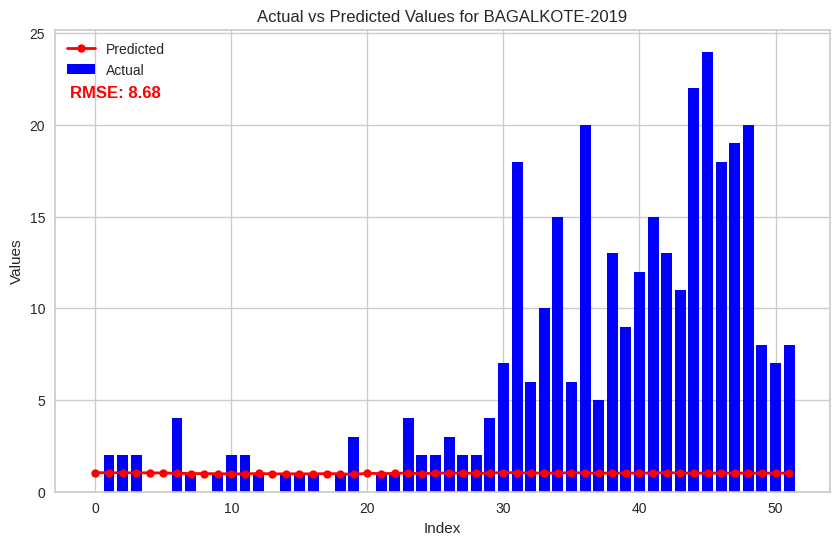

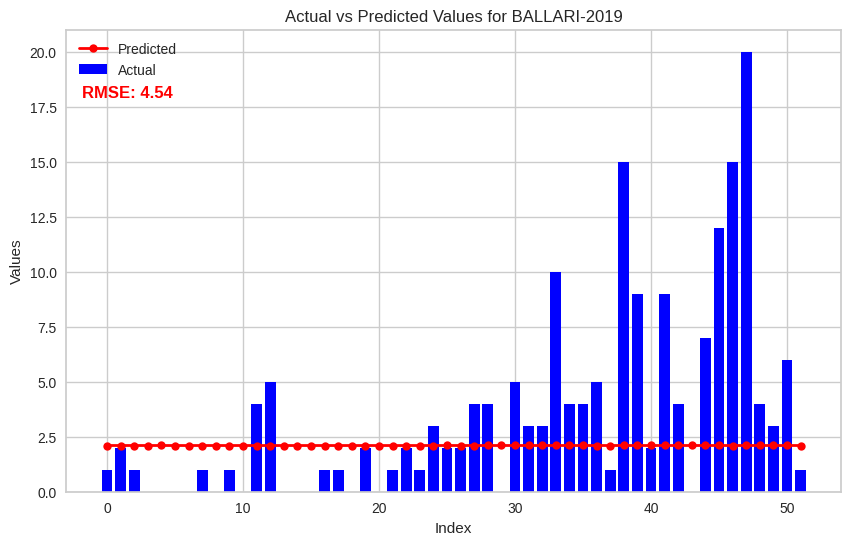

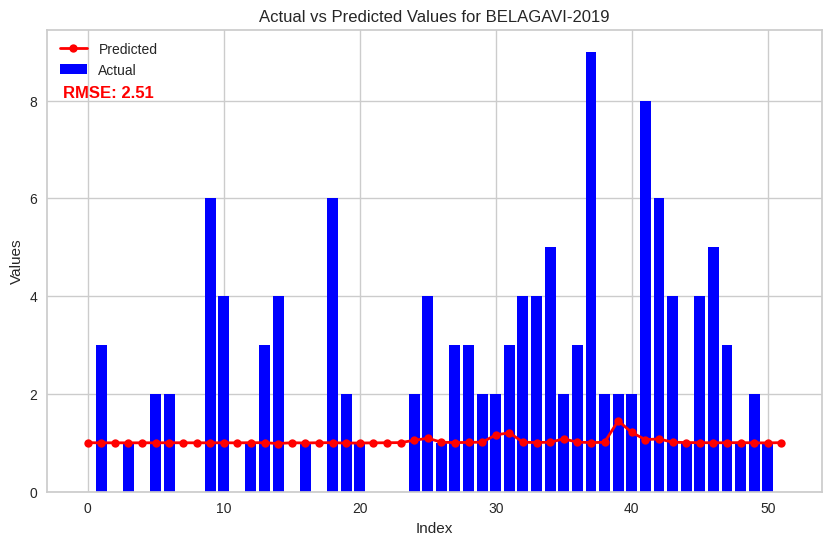

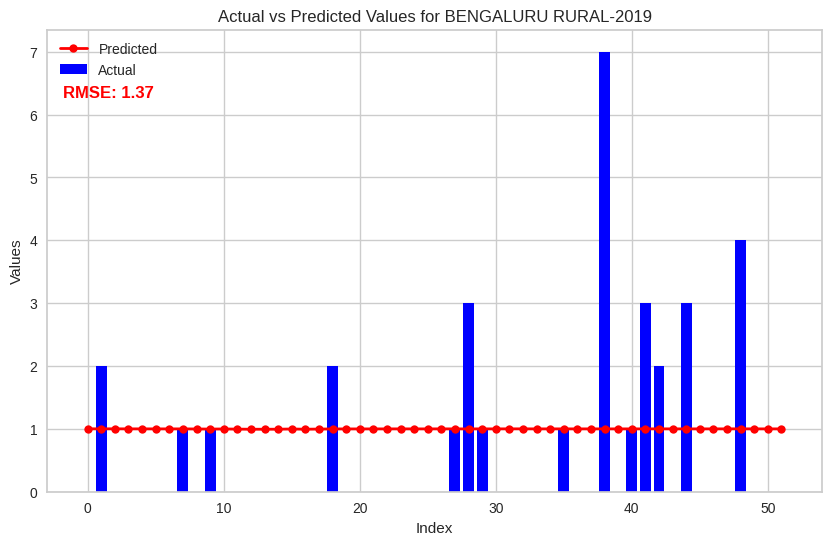

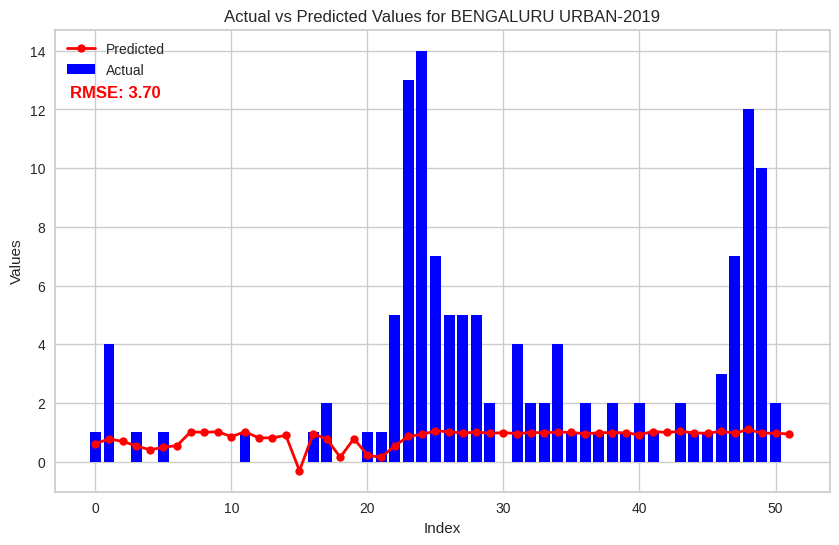

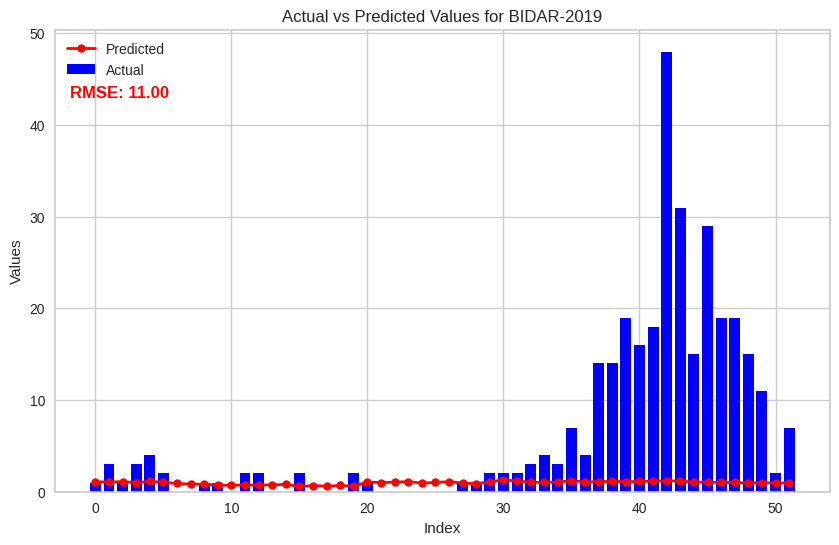

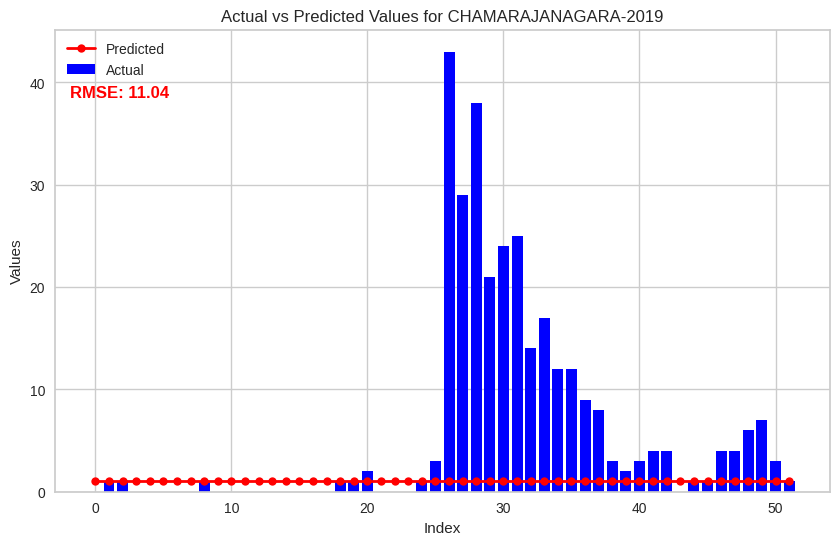

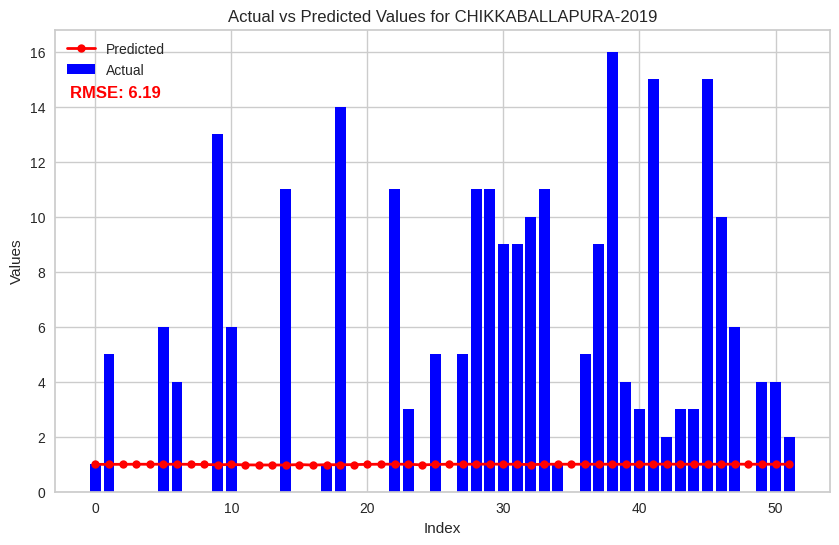

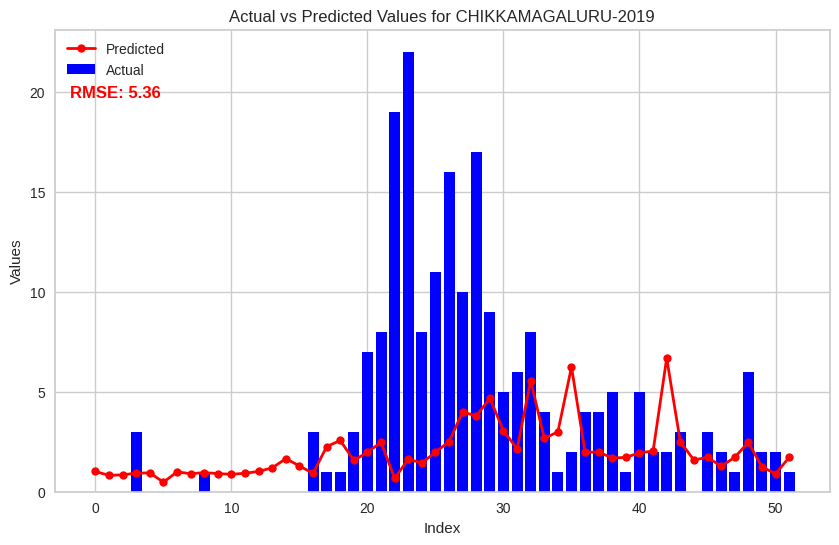

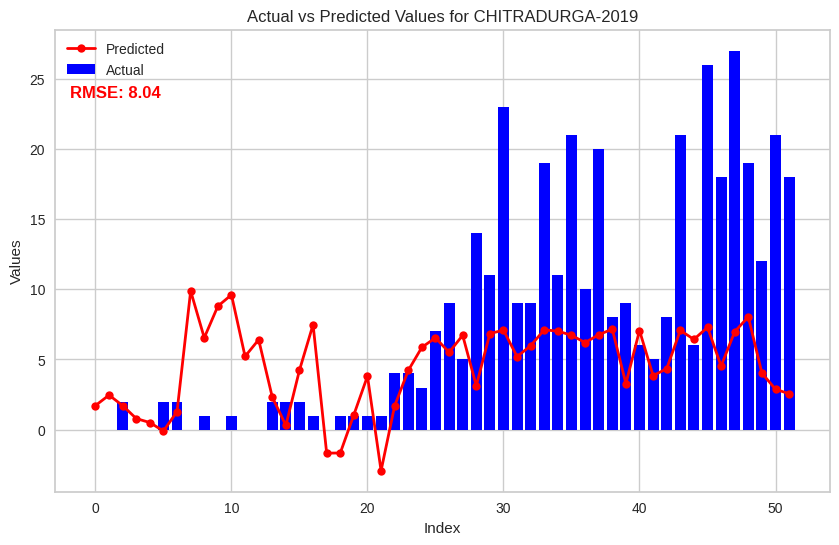

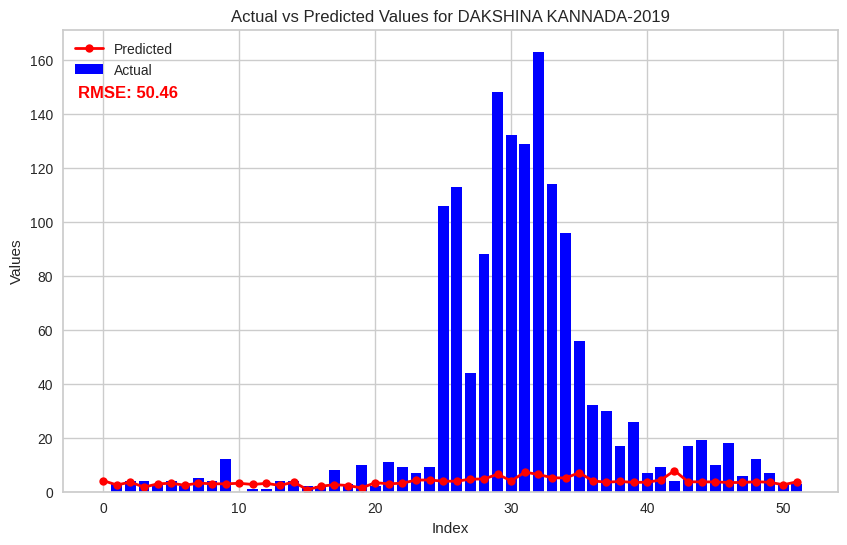

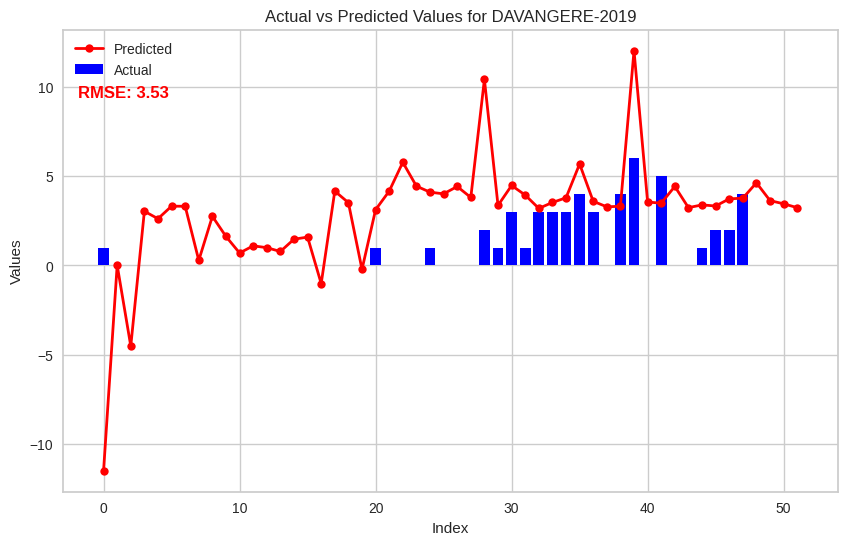

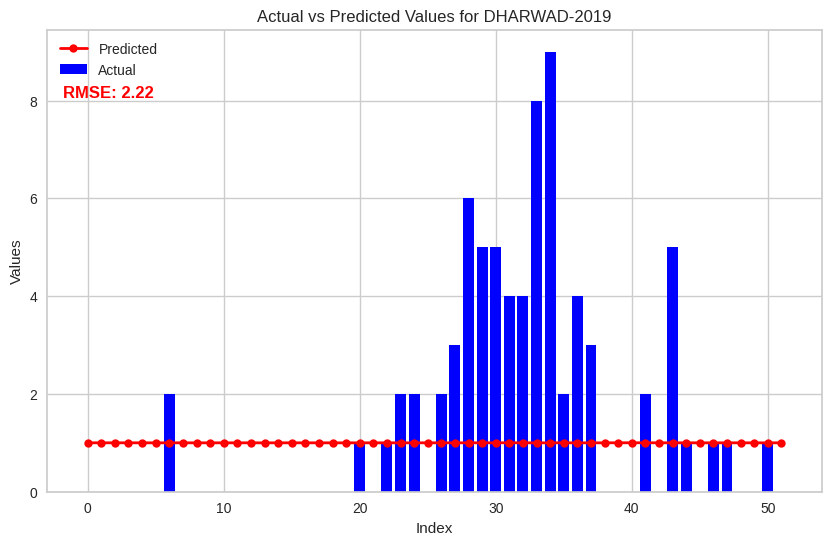

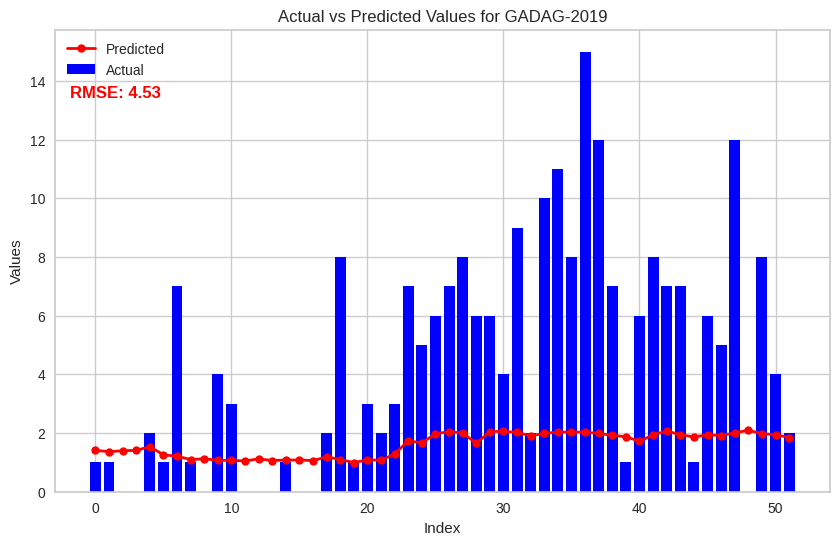

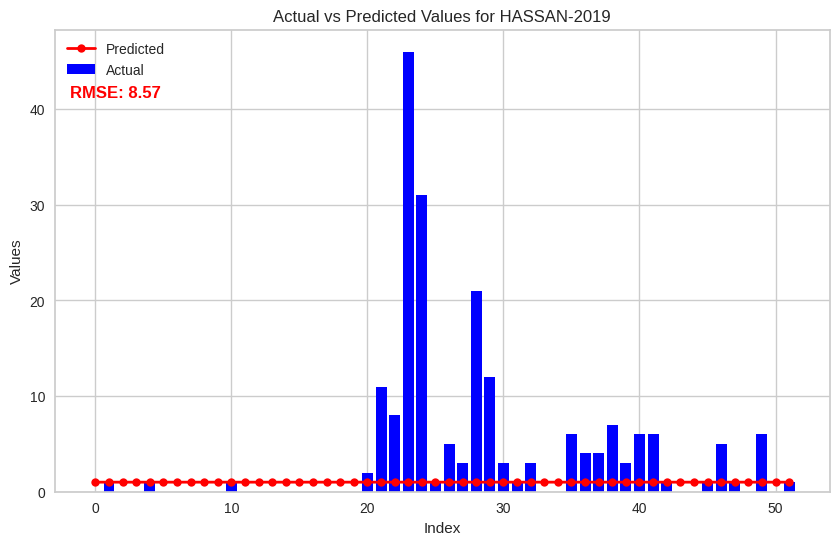

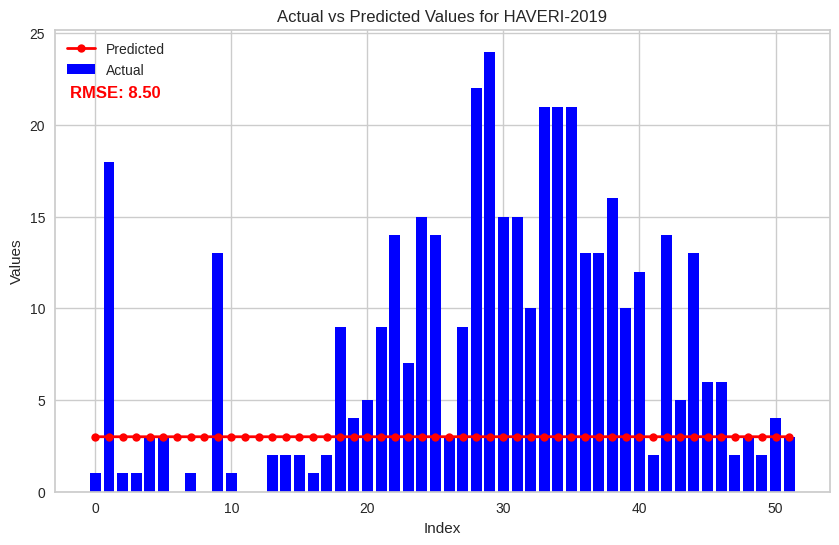

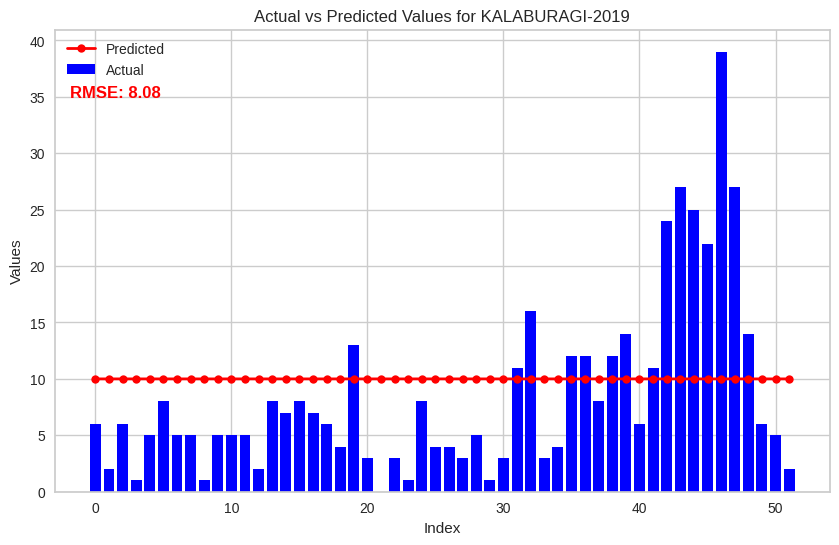

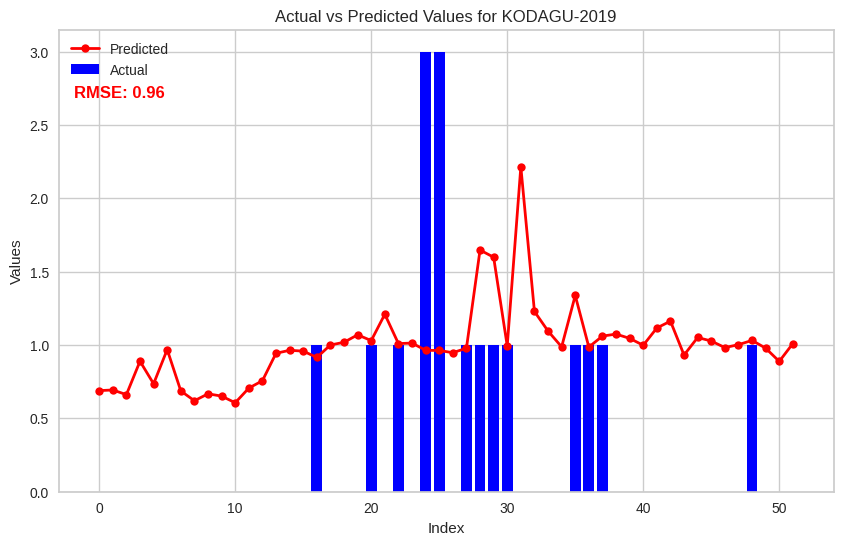

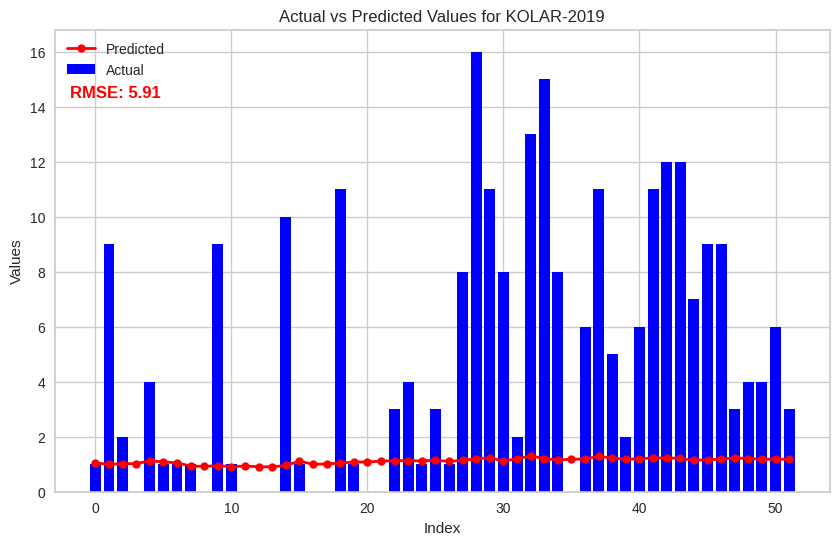

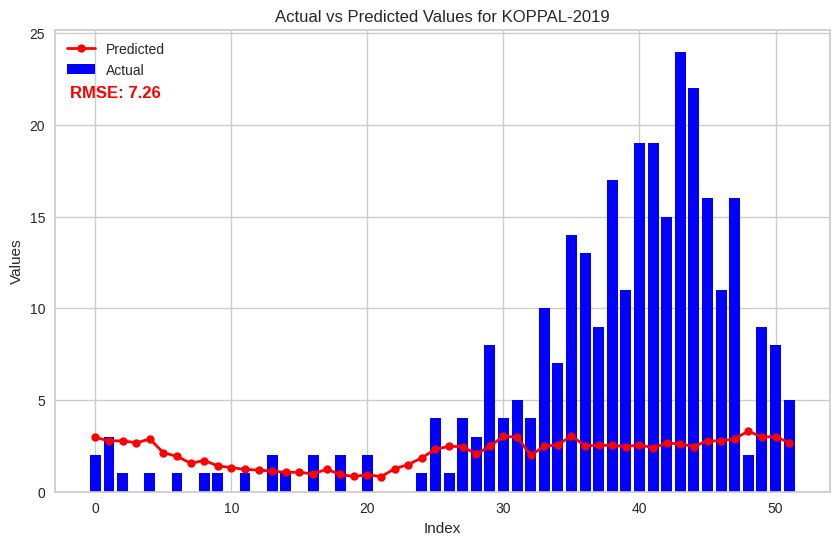

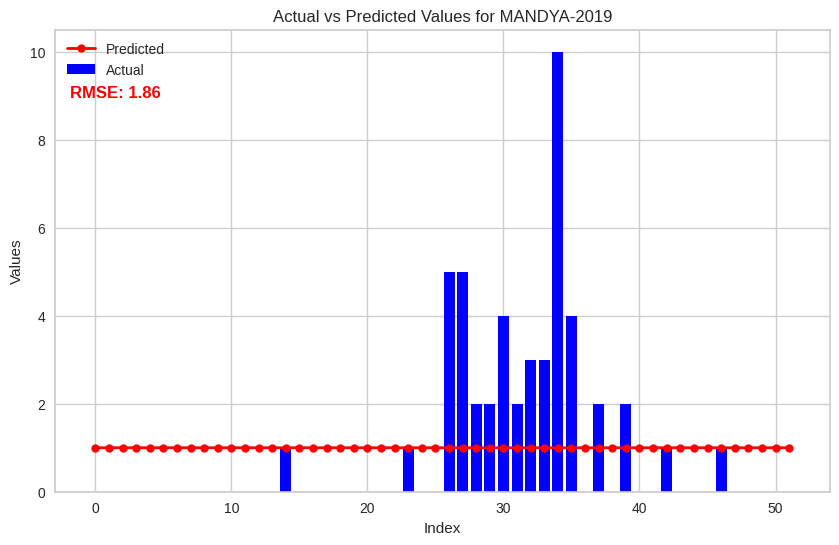

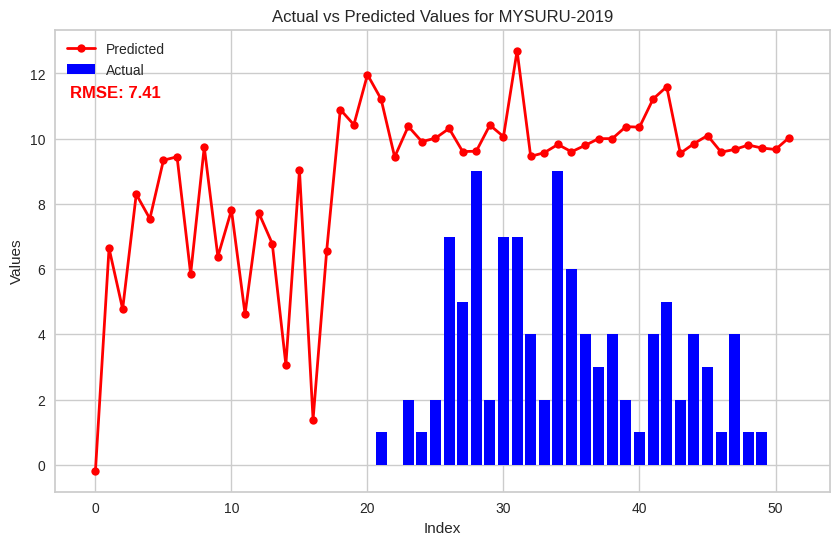

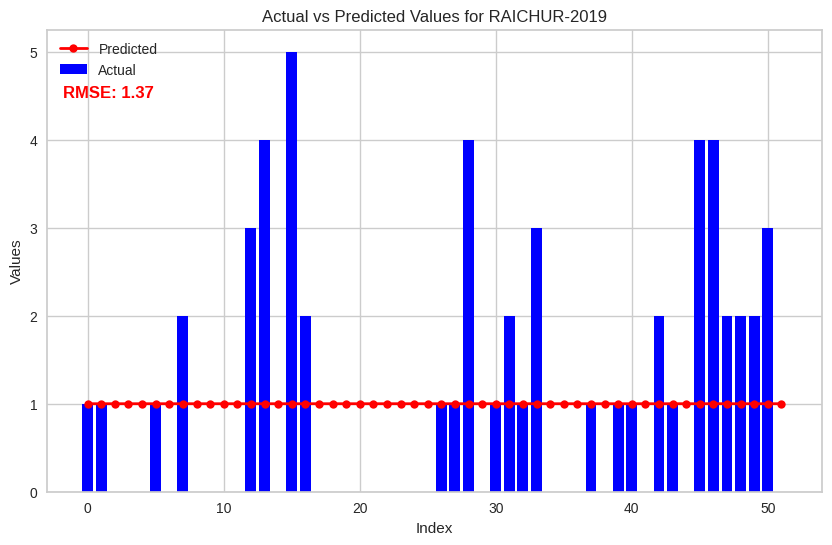

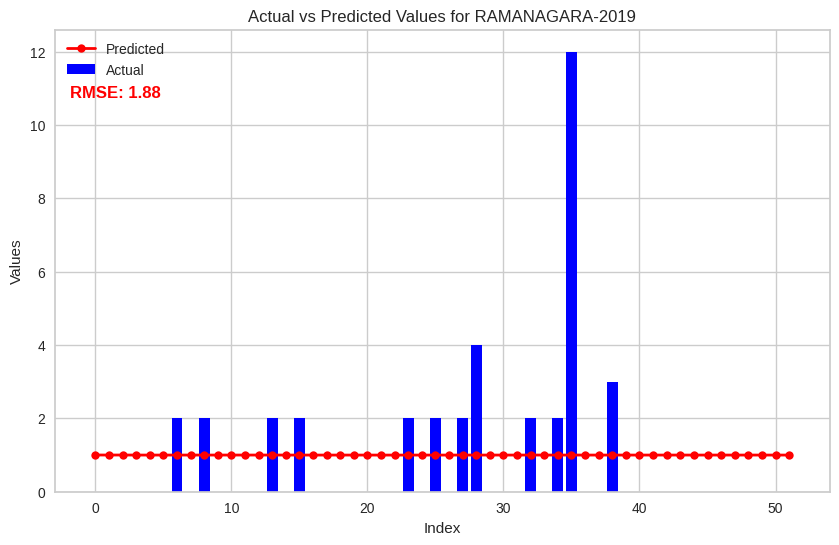

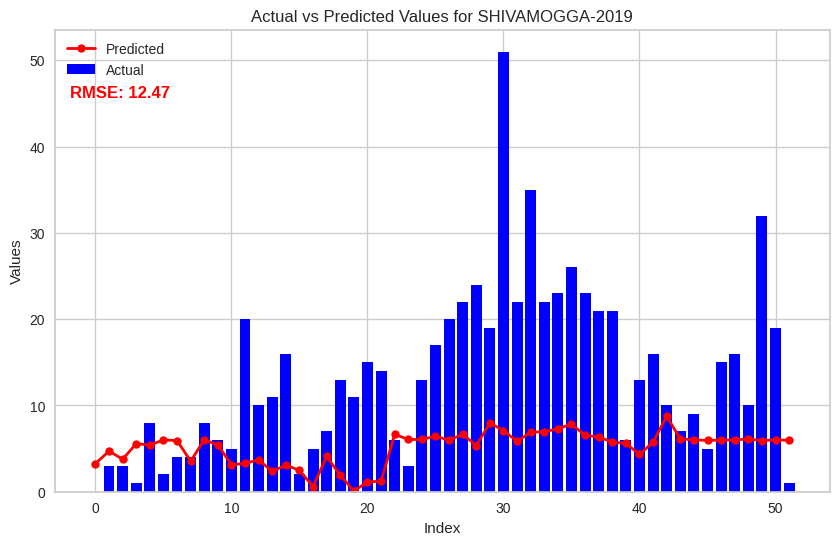

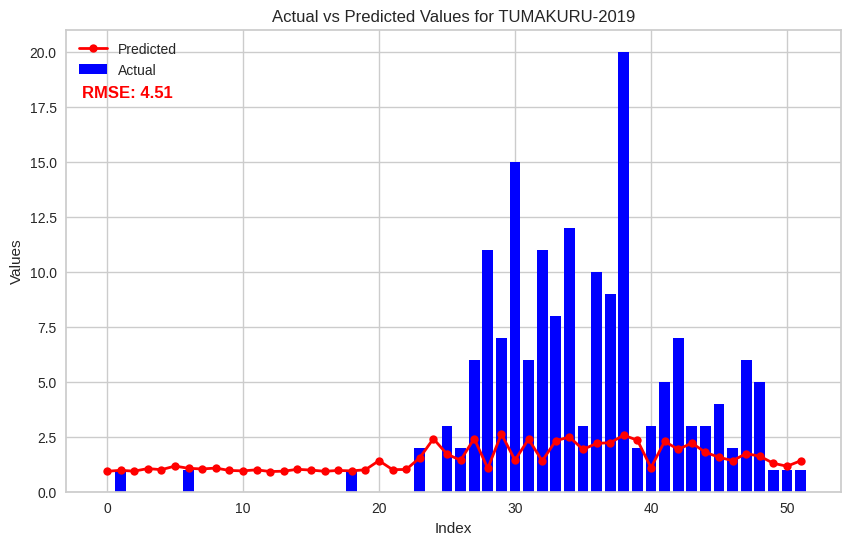

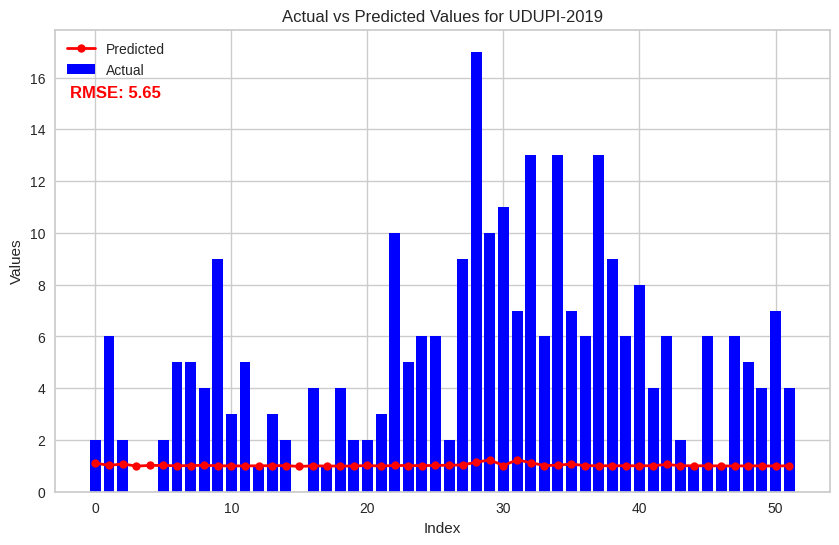

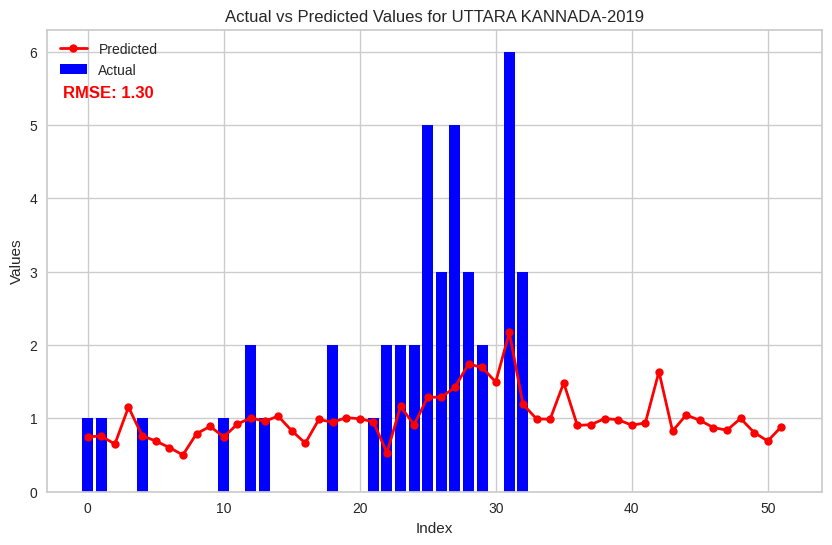

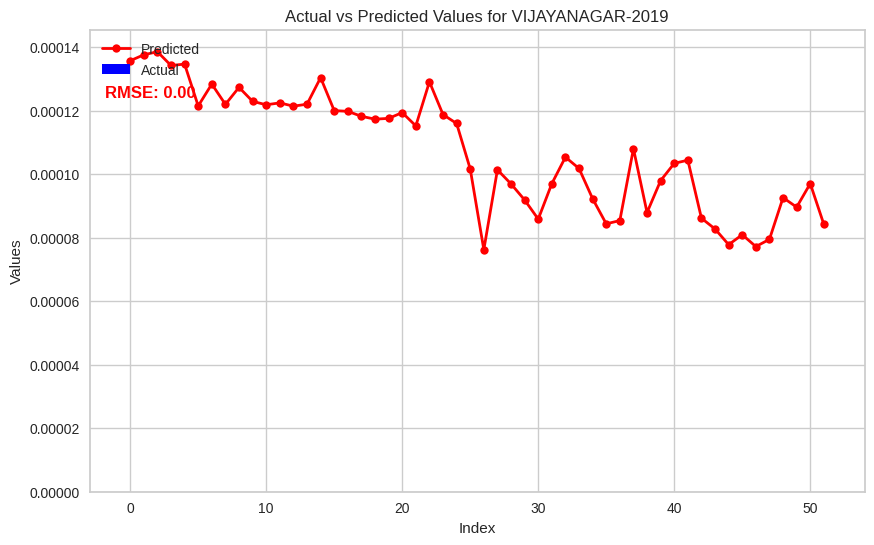

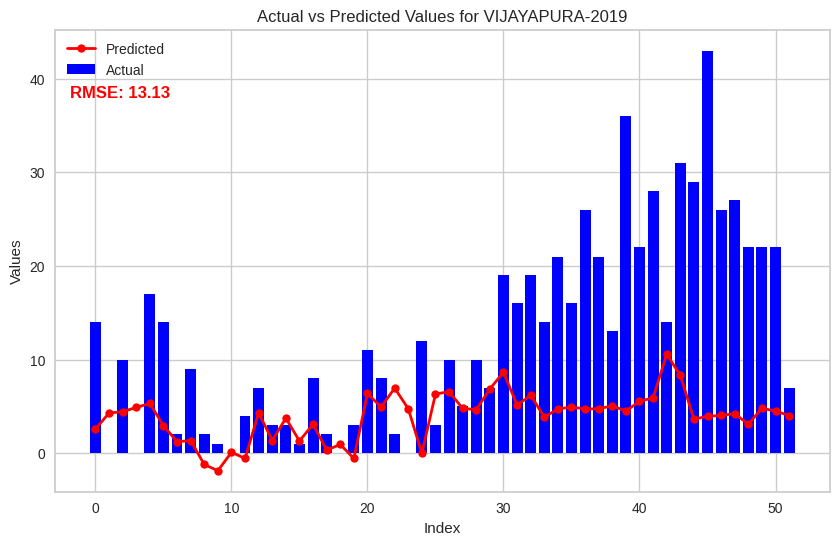

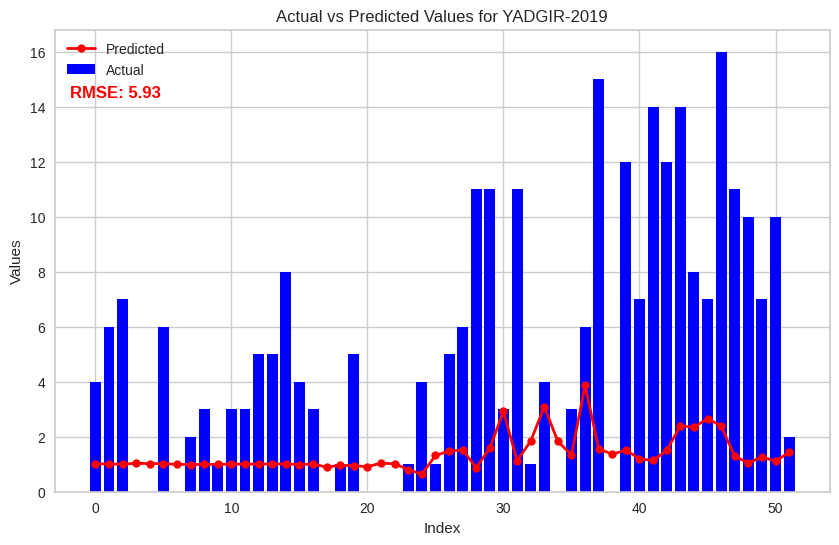

In [82]:
district_analysis = DistrictAnalysis("Karnataka_weather1980to2022.csv",2019)
df_2019 = district_analysis.analyze_districts()

In [83]:
df_2019

district  2019_rmse 2019_performance
0          BAGALKOTE   8.676442              Bad
1            BALLARI   4.538553              Bad
2           BELAGAVI   2.514647              Bad
3    BENGALURU RURAL   1.372300             Good
4    BENGALURU URBAN   3.702433              Bad
5              BIDAR  11.000734              Bad
6    CHAMARAJANAGARA  11.038323              Bad
7    CHIKKABALLAPURA   6.194725              Bad
8     CHIKKAMAGALURU   5.355821              Bad
9        CHITRADURGA   8.044177              Bad
10  DAKSHINA KANNADA  50.462013              Bad
11         DAVANGERE   3.528545              Bad
12           DHARWAD   2.218713              Bad
13             GADAG   4.530289              Bad
14            HASSAN   8.572097              Bad
15            HAVERI   8.504440              Bad
16        KALABURAGI   8.083643              Bad
17            KODAGU   0.956299             Good
18             KOLAR   5.905551              Bad
19            KOPPAL   7.255458              Bad
20            MANDYA   1.860550             Good
21            MYSURU   7.408192              Bad
22           RAICHUR   1.365774             Good
23        RAMANAGARA   1.875961             Good
24        SHIVAMOGGA  12.472385              Bad
25          TUMAKURU   4.511597              Bad
26             UDUPI   5.653992              Bad
27    UTTARA KANNADA   1.295504             Good
28       VIJAYANAGAR   0.000109             Good
29        VIJAYAPURA  13.128701              Bad
30            YADGIR   5.929639              Bad

Analyzing District: BAGALKOTE
Analyzing District: BALLARI
Analyzing District: BELAGAVI
Analyzing District: BENGALURU RURAL
Analyzing District: BENGALURU URBAN
Analyzing District: BIDAR
Analyzing District: CHAMARAJANAGARA
Analyzing District: CHIKKABALLAPURA
Analyzing District: CHIKKAMAGALURU
Analyzing District: CHITRADURGA
Analyzing District: DAKSHINA KANNADA
Analyzing District: DAVANGERE
Analyzing District: DHARWAD
Analyzing District: GADAG
Analyzing District: HASSAN
Analyzing District: HAVERI
Analyzing District: KALABURAGI
Analyzing District: KODAGU
Analyzing District: KOLAR
Analyzing District: KOPPAL
Analyzing District: MANDYA
Analyzing District: MYSURU
Analyzing District: RAICHUR
Analyzing District: RAMANAGARA
Analyzing District: SHIVAMOGGA
Analyzing District: TUMAKURU
Analyzing District: UDUPI
Analyzing District: UTTARA KANNADA
Analyzing District: VIJAYANAGAR
Analyzing District: VIJAYAPURA
Analyzing District: YADGIR


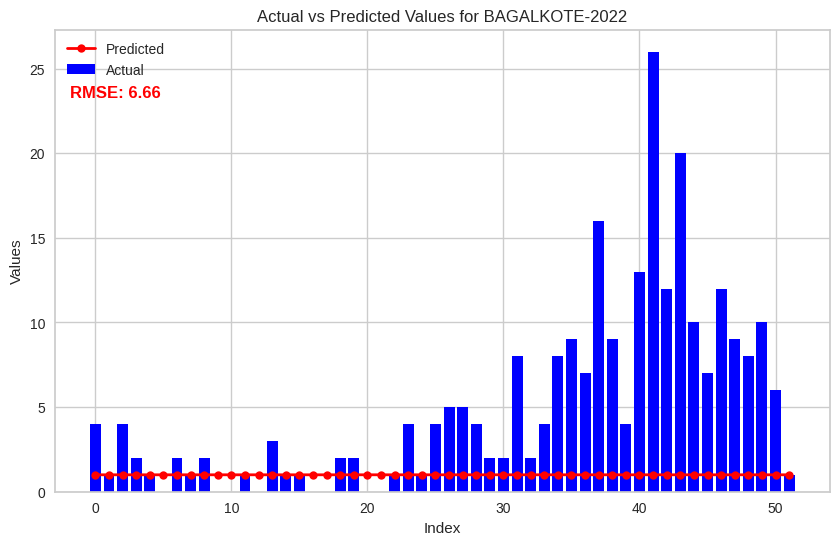

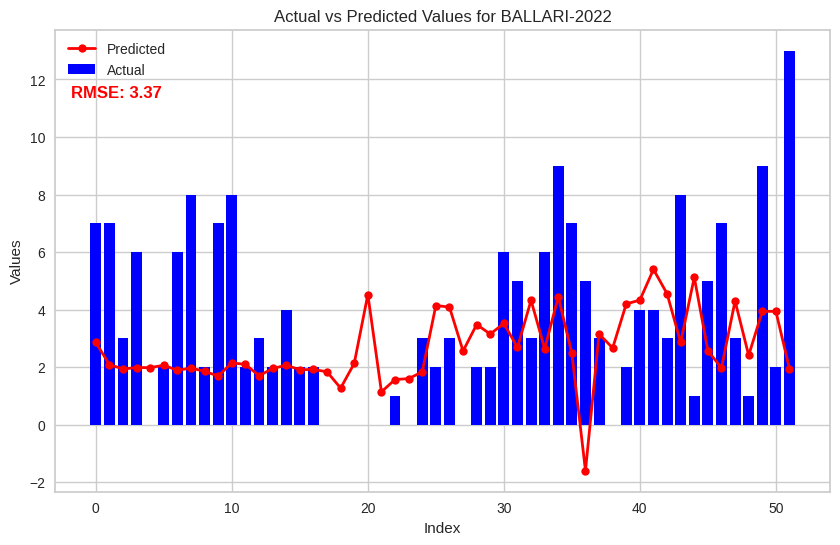

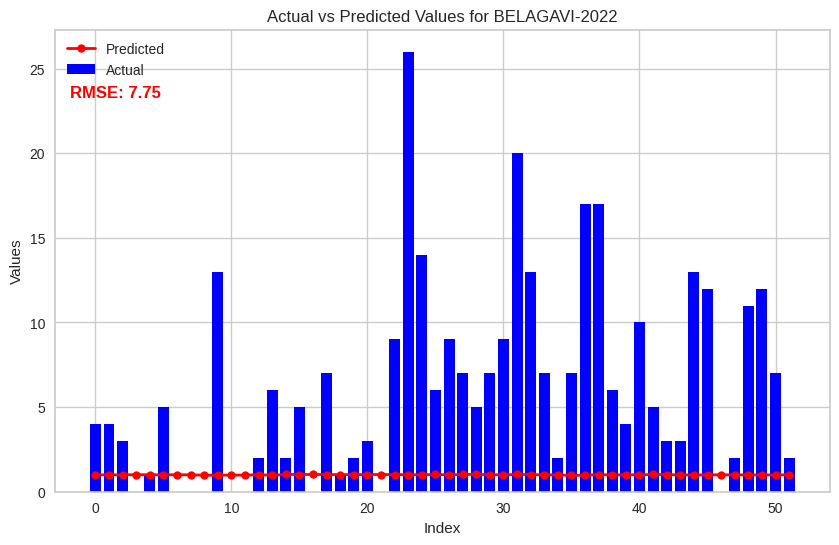

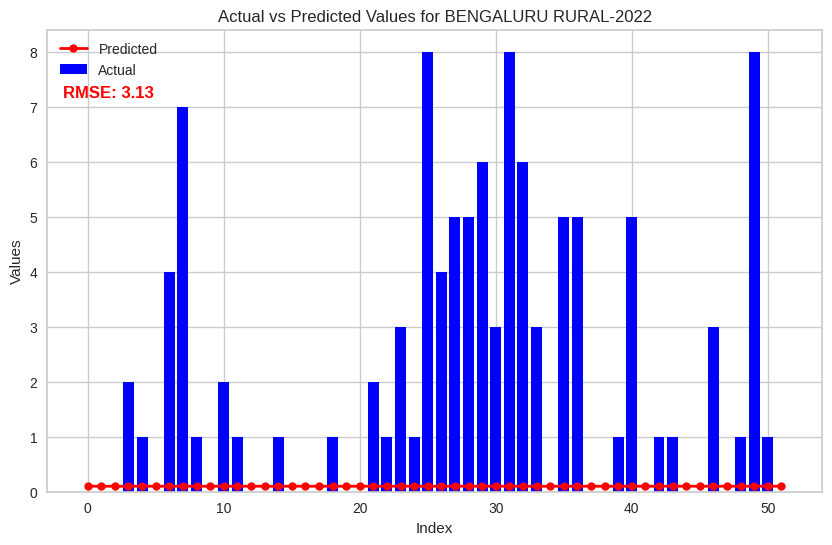

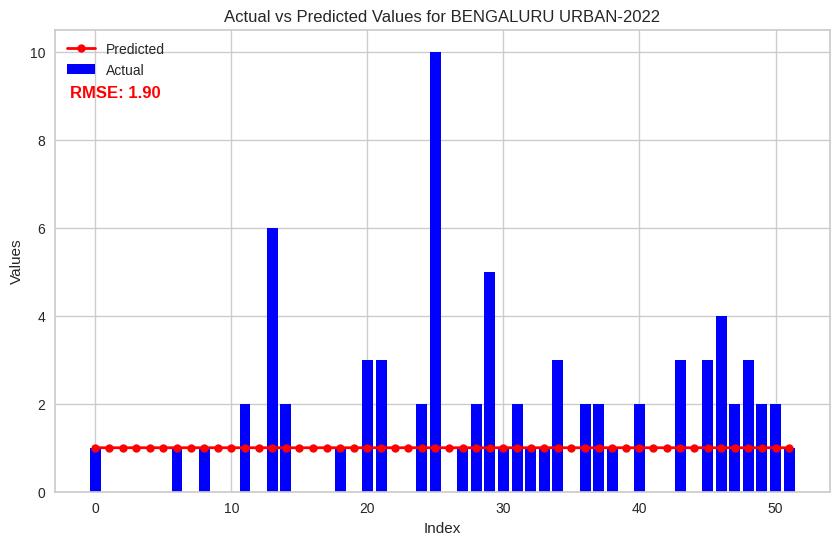

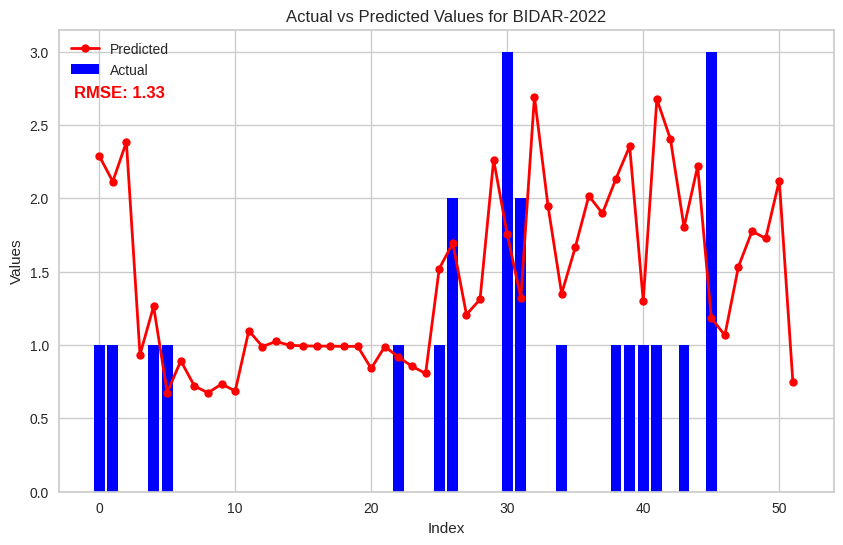

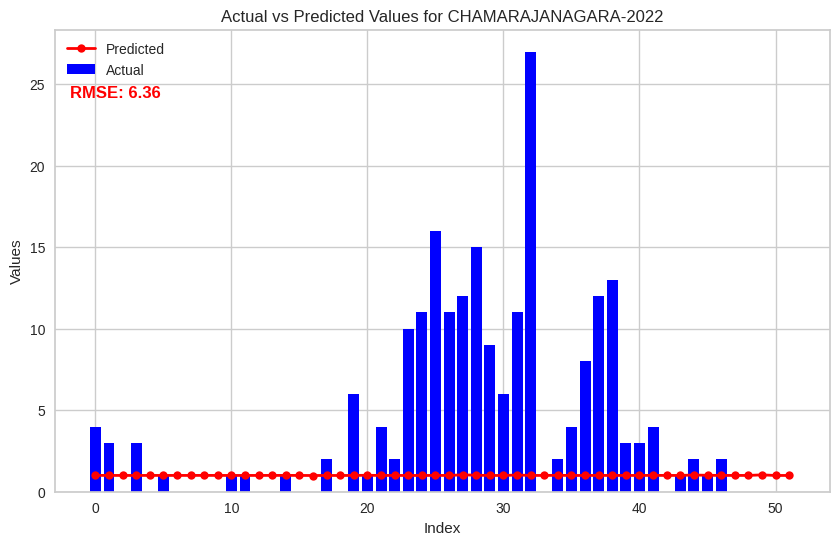

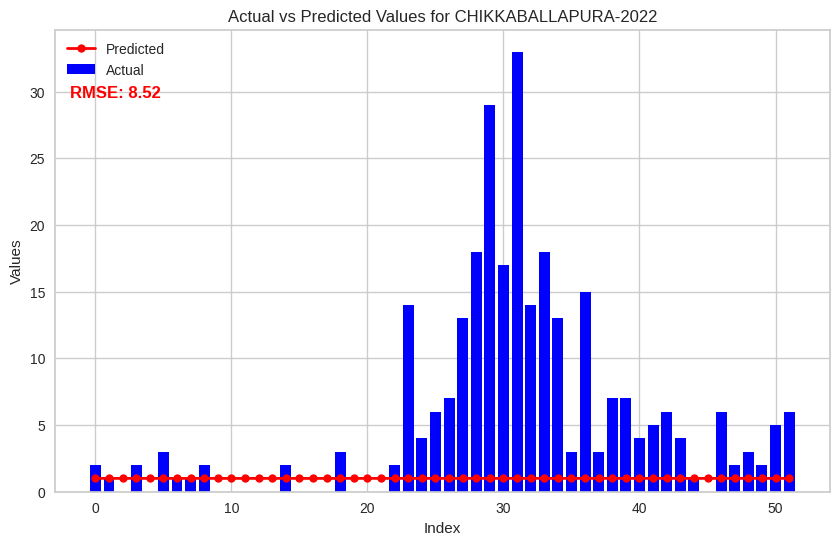

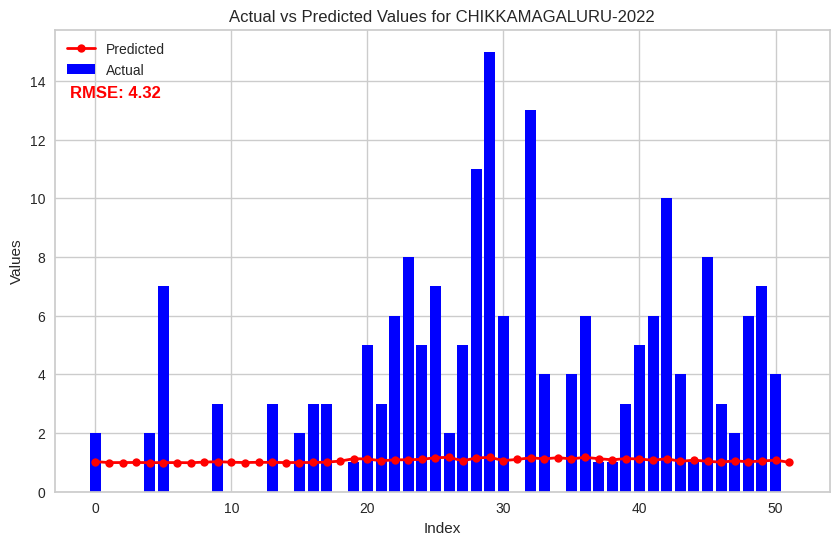

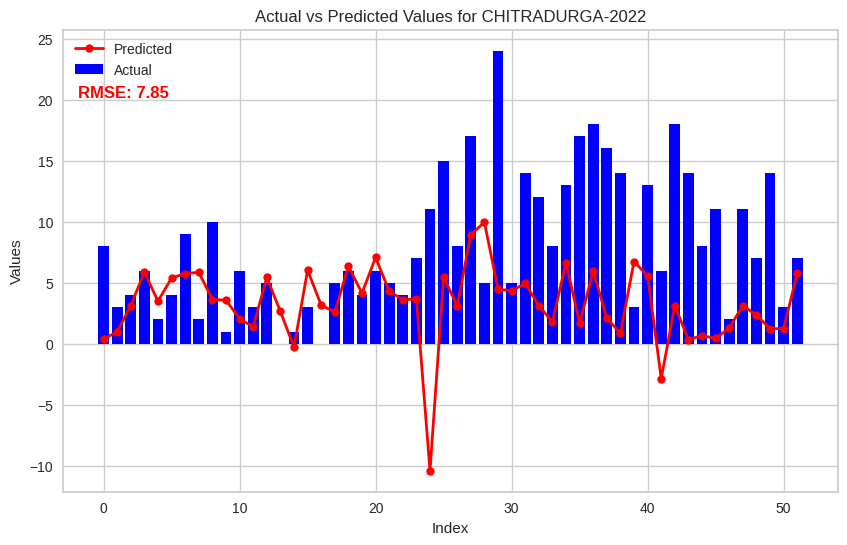

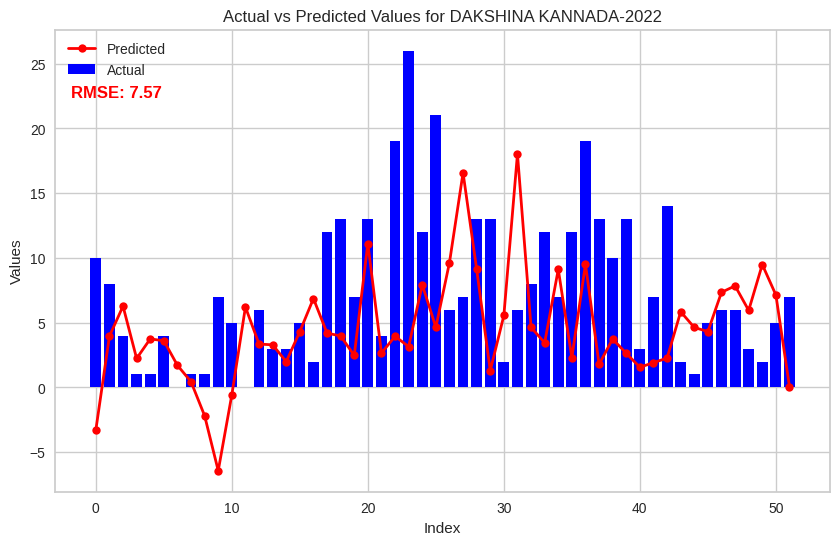

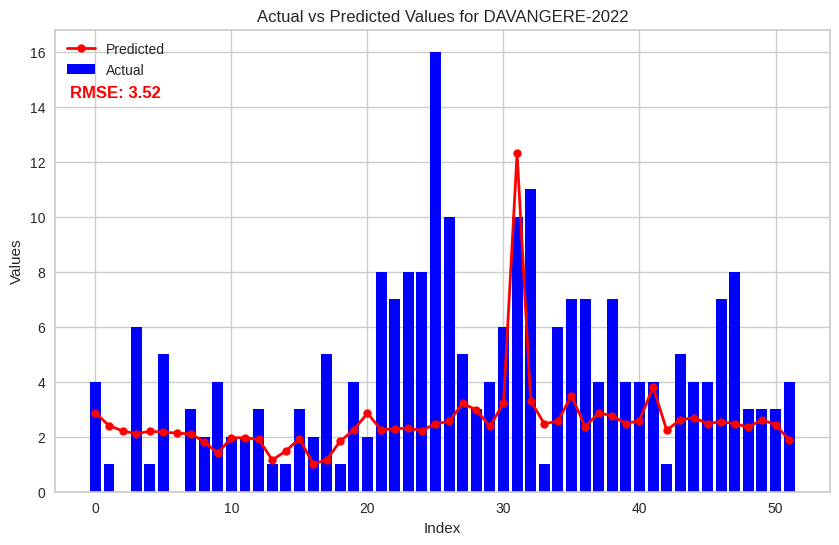

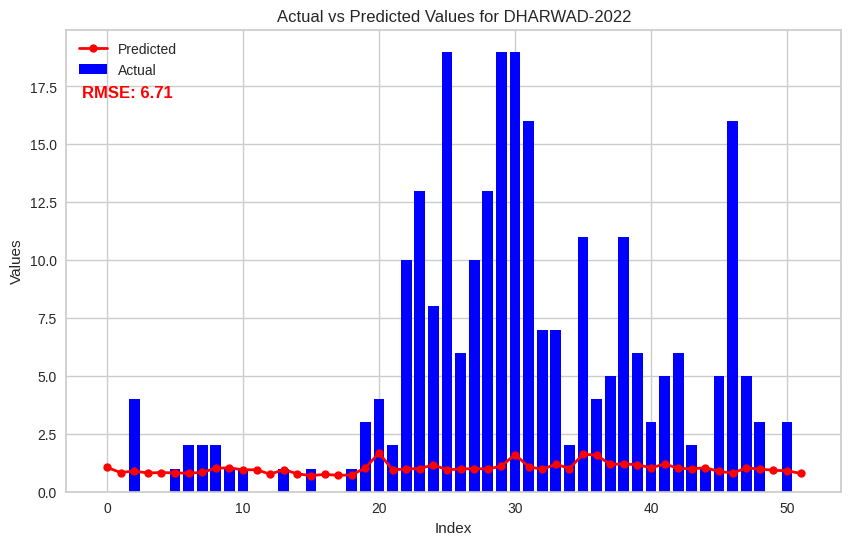

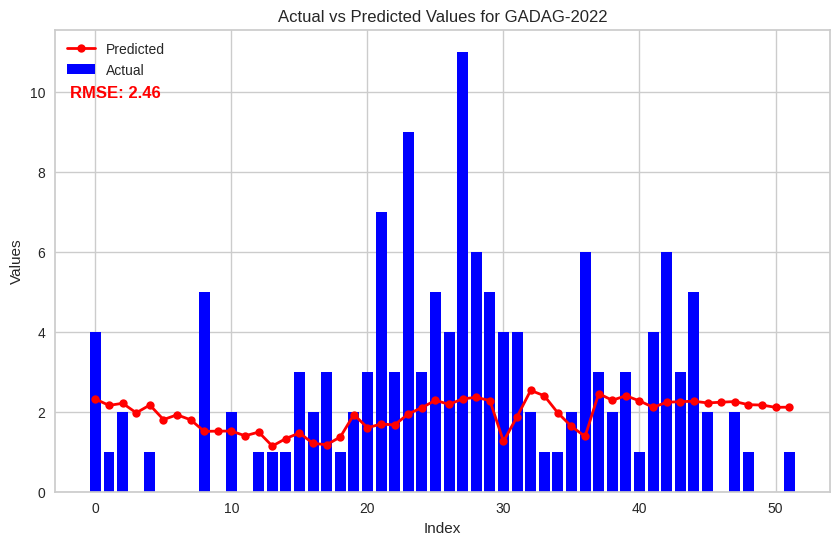

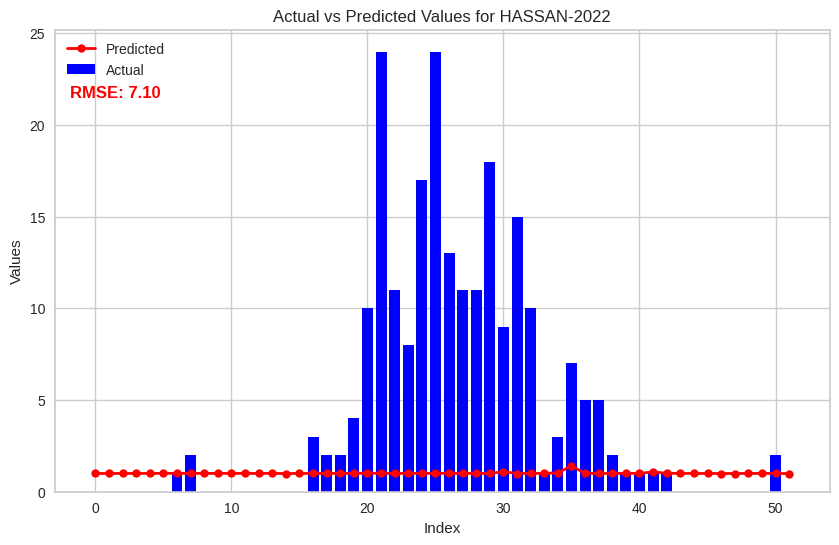

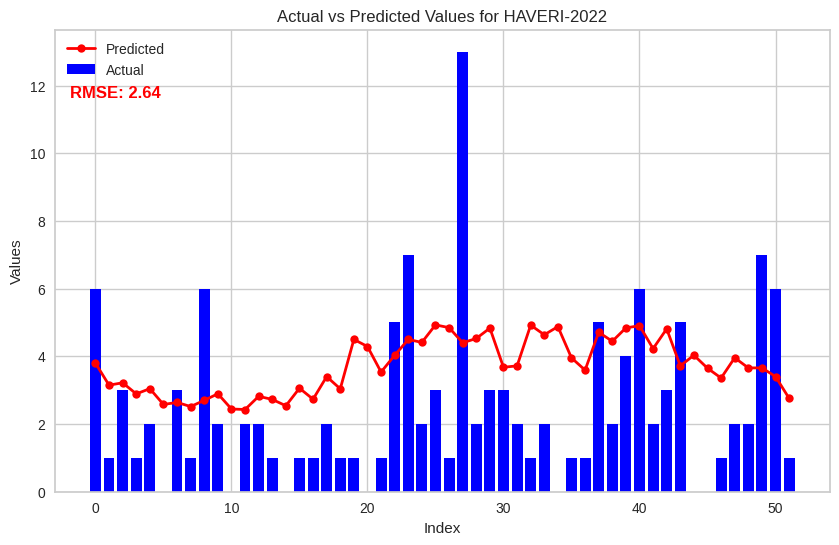

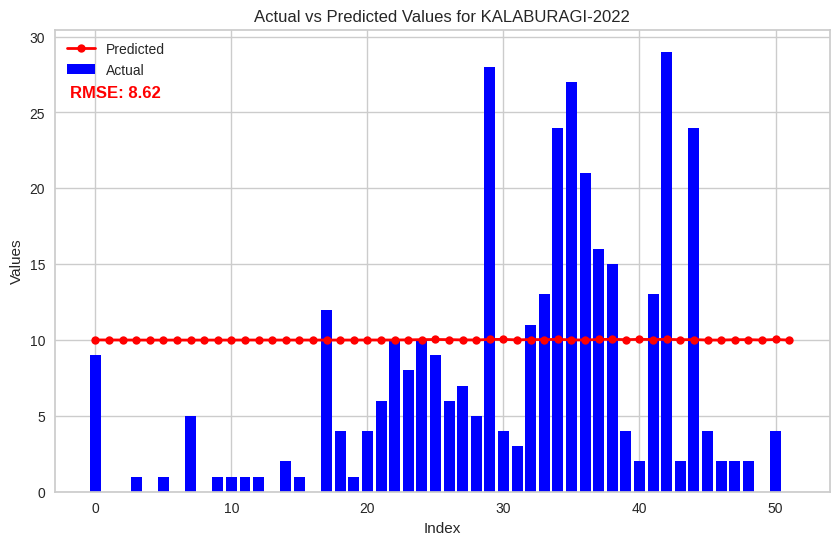

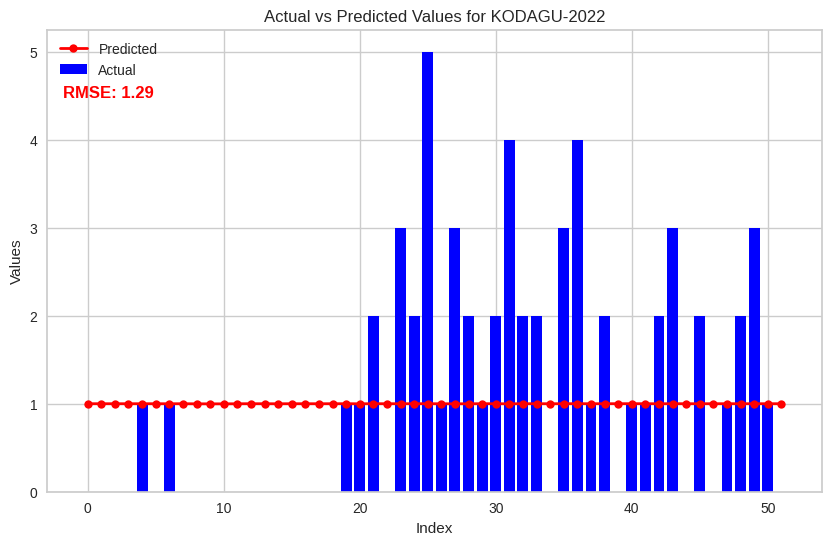

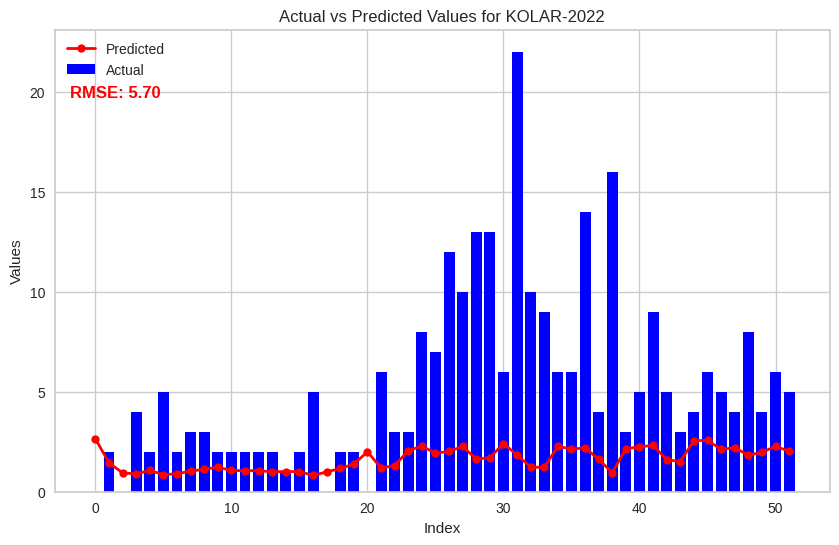

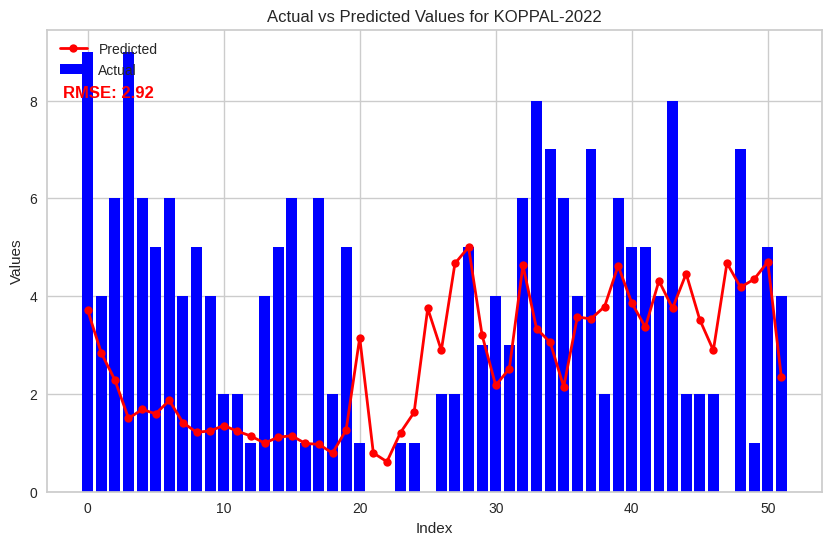

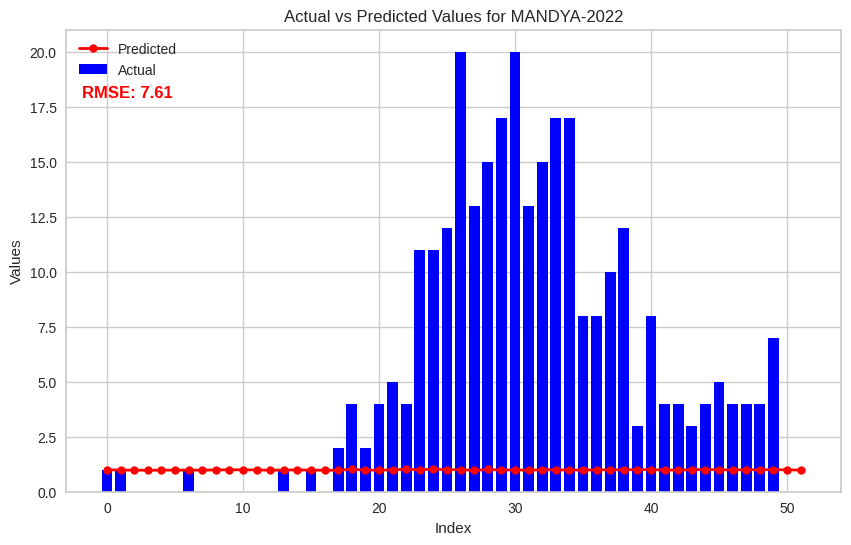

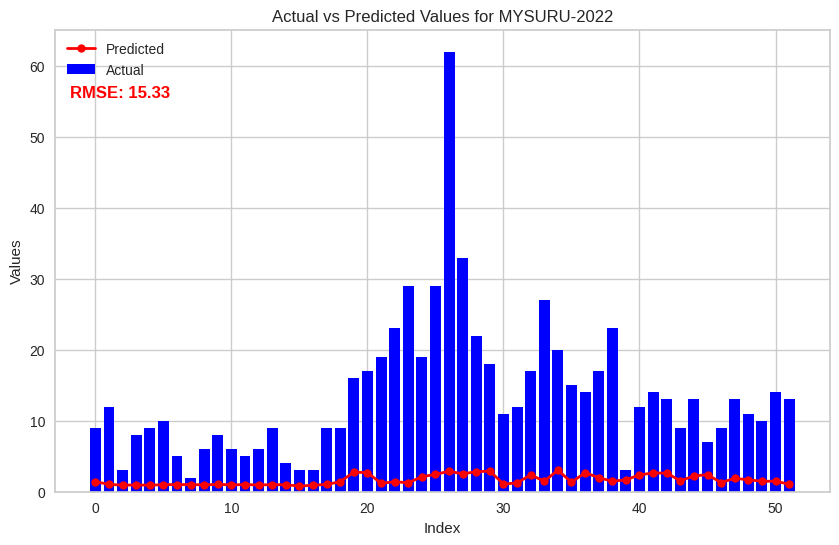

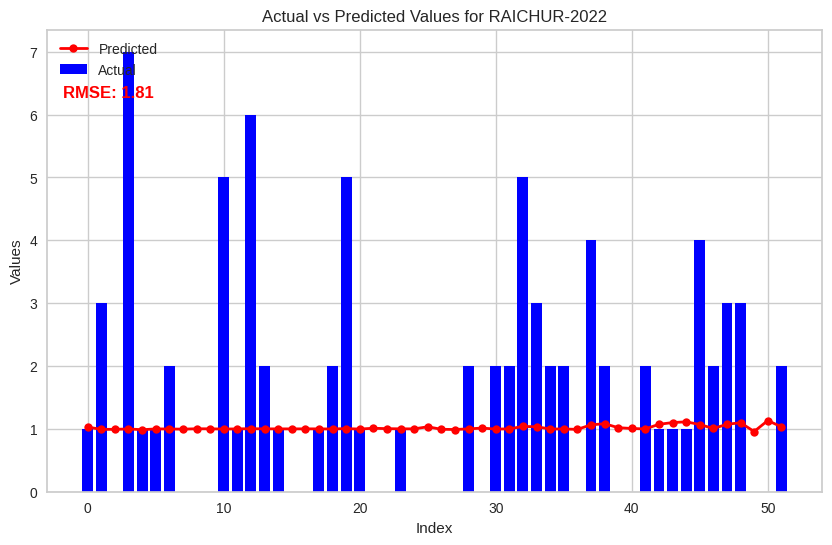

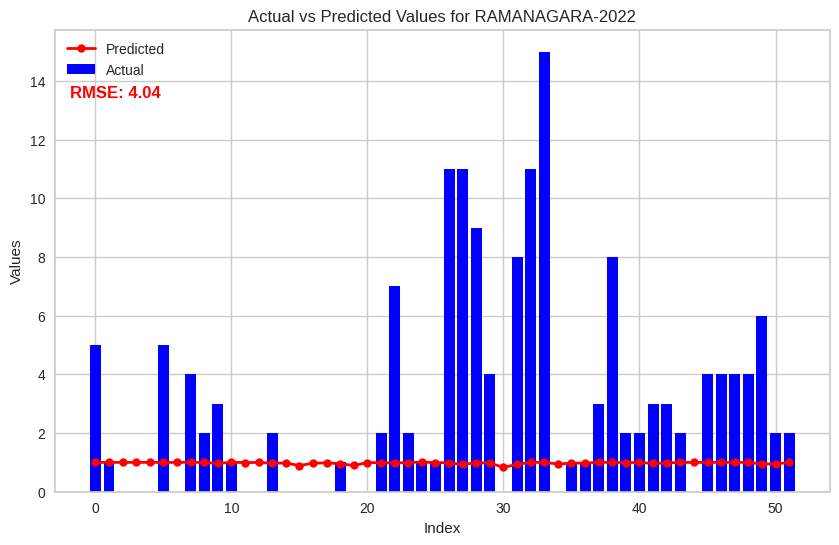

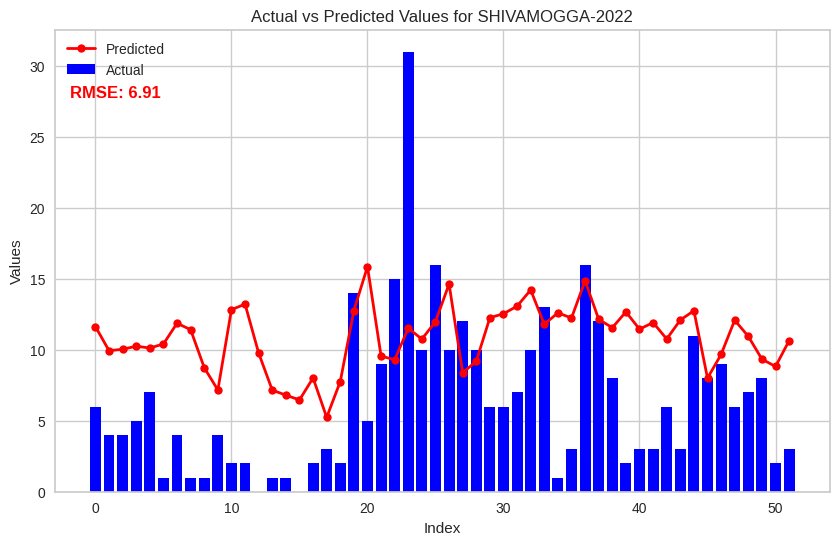

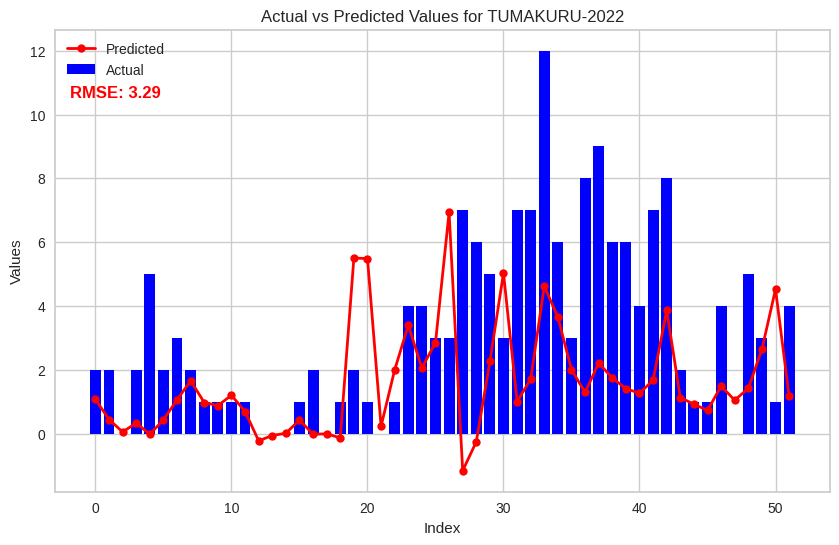

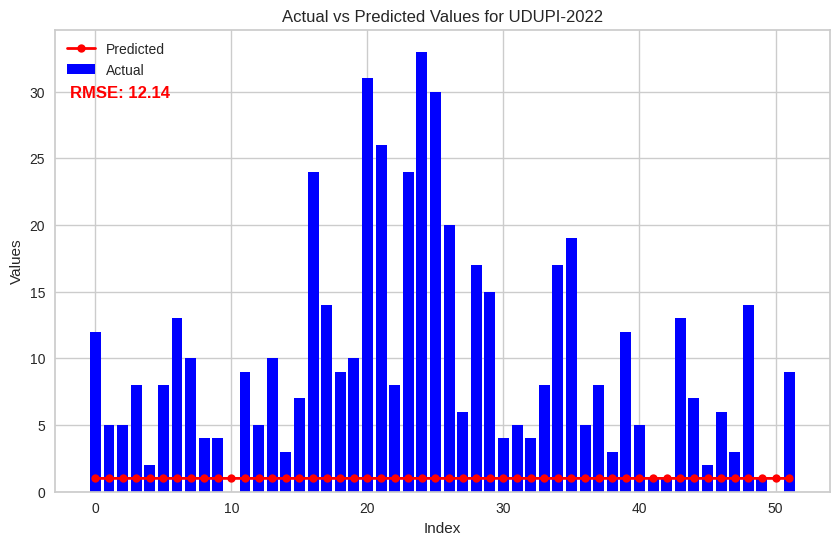

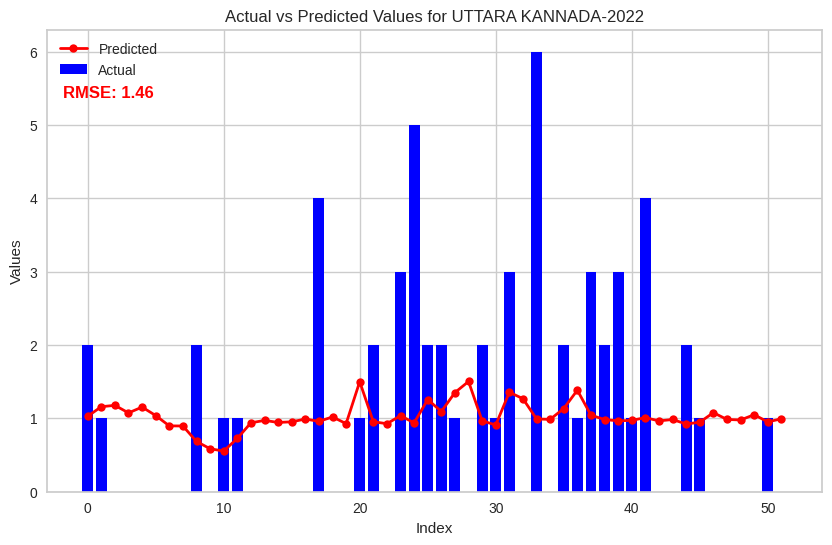

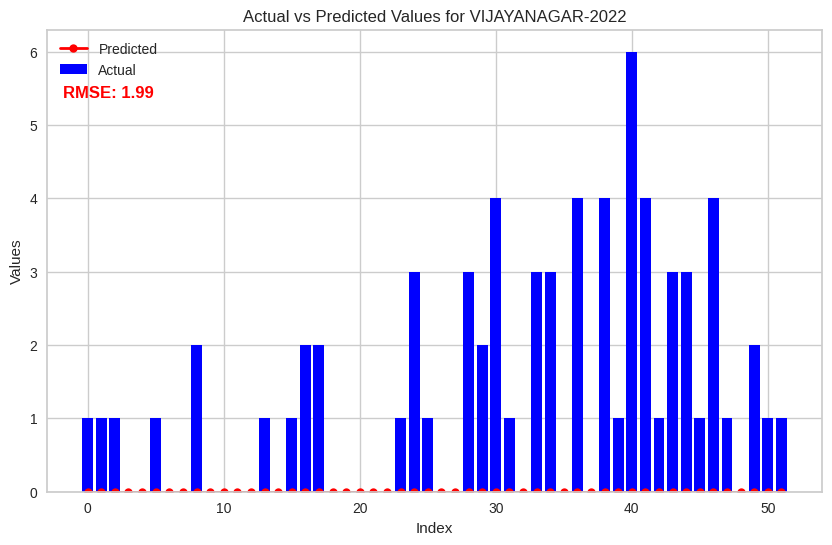

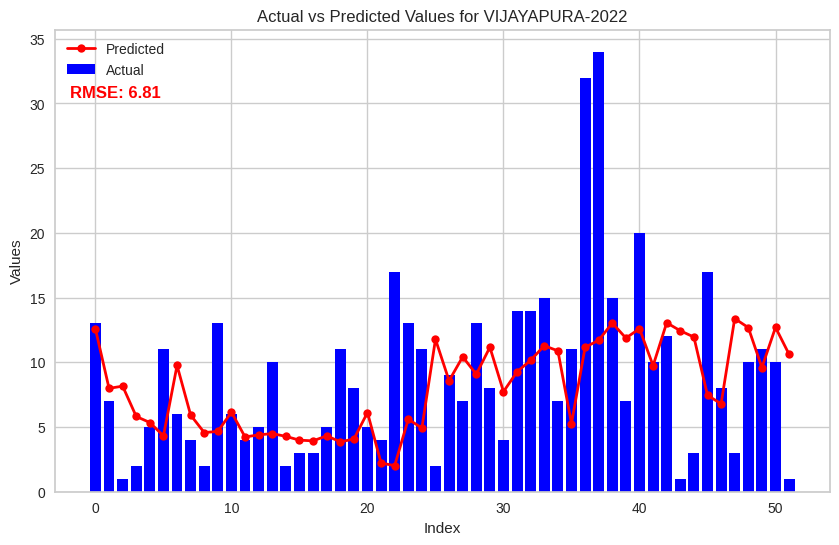

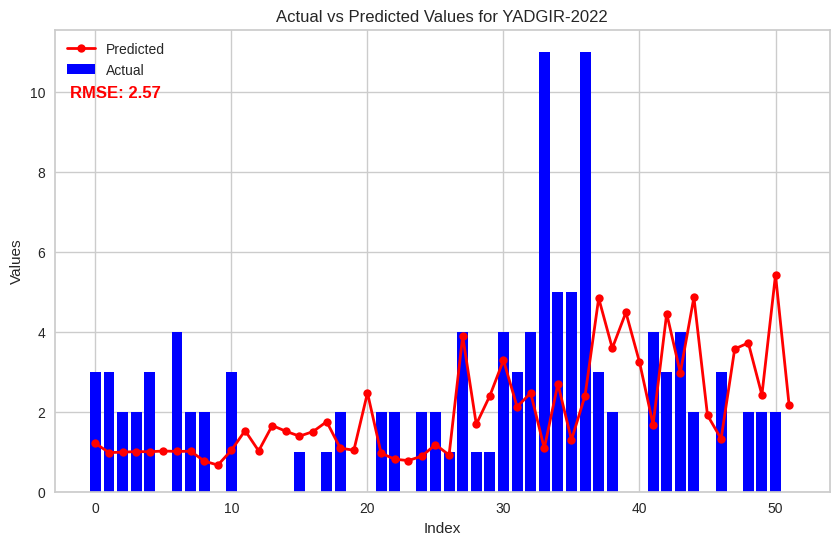

In [84]:
district_analysis = DistrictAnalysis("Karnataka_weather1980to2022.csv",2022)
df_2022 = district_analysis.analyze_districts()

In [85]:
df_2022

district  2022_rmse 2022_performance
0          BAGALKOTE   6.664714              Bad
1            BALLARI   3.369215              Bad
2           BELAGAVI   7.753599              Bad
3    BENGALURU RURAL   3.129632              Bad
4    BENGALURU URBAN   1.896386             Good
5              BIDAR   1.332329             Good
6    CHAMARAJANAGARA   6.355564              Bad
7    CHIKKABALLAPURA   8.516946              Bad
8     CHIKKAMAGALURU   4.321594              Bad
9        CHITRADURGA   7.851477              Bad
10  DAKSHINA KANNADA   7.570694              Bad
11         DAVANGERE   3.517203              Bad
12           DHARWAD   6.709894              Bad
13             GADAG   2.457180              Bad
14            HASSAN   7.103158              Bad
15            HAVERI   2.640169              Bad
16        KALABURAGI   8.616313              Bad
17            KODAGU   1.293441             Good
18             KOLAR   5.699573              Bad
19            KOPPAL   2.918078              Bad
20            MANDYA   7.614335              Bad
21            MYSURU  15.327912              Bad
22           RAICHUR   1.814618             Good
23        RAMANAGARA   4.039171              Bad
24        SHIVAMOGGA   6.912500              Bad
25          TUMAKURU   3.292305              Bad
26             UDUPI  12.136182              Bad
27    UTTARA KANNADA   1.457459             Good
28       VIJAYANAGAR   1.985525             Good
29        VIJAYAPURA   6.810820              Bad
30            YADGIR   2.571081              Bad

In [86]:
from functools import reduce

# List of DataFrames to merge
dfs = [df_2017, df_2018, df_2019, df_2022]

# Function to merge two DataFrames on 'district' with suffixes
def merge_dfs(left, right):
    return pd.merge(left, right, on='district', suffixes=('', f"_{right.columns[-1][-4:]}"))

# Use reduce to iteratively merge all DataFrames
merged_df = reduce(merge_dfs, dfs)

merged_df

district  2017_rmse 2017_performance  2018_rmse 2018_performance  \
0          BAGALKOTE   6.915504              Bad   2.157593              Bad   
1            BALLARI  10.880000              Bad   2.635411              Bad   
2           BELAGAVI   1.256539             Good   1.387086             Good   
3    BENGALURU RURAL   0.854630             Good   0.970509             Good   
4    BENGALURU URBAN   0.983121             Good   1.081871             Good   
5              BIDAR   5.723328              Bad   3.406929              Bad   
6    CHAMARAJANAGARA   1.177380             Good   2.108141              Bad   
7    CHIKKABALLAPURA   1.169345             Good   1.674109             Good   
8     CHIKKAMAGALURU   7.135522              Bad   2.016957              Bad   
9        CHITRADURGA   9.949612              Bad   4.363978              Bad   
10  DAKSHINA KANNADA   9.384641              Bad  13.600531              Bad   
11         DAVANGERE  21.011381              Bad   2.200556              Bad   
12           DHARWAD   1.608420             Good   2.541935              Bad   
13             GADAG   5.101642              Bad   2.141566              Bad   
14            HASSAN   1.223690             Good   9.049327              Bad   
15            HAVERI   7.751207              Bad   3.150555              Bad   
16        KALABURAGI  29.065948              Bad  17.992814              Bad   
17            KODAGU   8.726739              Bad   1.107638             Good   
18             KOLAR   8.219229              Bad   2.051030              Bad   
19            KOPPAL   4.122887              Bad   2.810984              Bad   
20            MANDYA   1.000033             Good   0.999999             Good   
21            MYSURU  25.964426              Bad   8.494255              Bad   
22           RAICHUR   3.399759              Bad   1.681381             Good   
23        RAMANAGARA   8.418929              Bad   1.047003             Good   
24        SHIVAMOGGA  12.121652              Bad   6.951225              Bad   
25          TUMAKURU  15.948241              Bad   2.563135              Bad   
26             UDUPI   3.258533              Bad   4.083122              Bad   
27    UTTARA KANNADA   0.999997             Good   2.139263              Bad   
28       VIJAYANAGAR   0.000164             Good   0.000111             Good   
29        VIJAYAPURA   5.306299              Bad   5.234098              Bad   
30            YADGIR   1.690699             Good   1.246212             Good   

    2019_rmse 2019_performance  2022_rmse 2022_performance  
0    8.676442              Bad   6.664714              Bad  
1    4.538553              Bad   3.369215              Bad  
2    2.514647              Bad   7.753599              Bad  
3    1.372300             Good   3.129632              Bad  
4    3.702433              Bad   1.896386             Good  
5   11.000734              Bad   1.332329             Good  
6   11.038323              Bad   6.355564              Bad  
7    6.194725              Bad   8.516946              Bad  
8    5.355821              Bad   4.321594              Bad  
9    8.044177              Bad   7.851477              Bad  
10  50.462013              Bad   7.570694              Bad  
11   3.528545              Bad   3.517203              Bad  
12   2.218713              Bad   6.709894              Bad  
13   4.530289              Bad   2.457180              Bad  
14   8.572097              Bad   7.103158              Bad  
15   8.504440              Bad   2.640169              Bad  
16   8.083643              Bad   8.616313              Bad  
17   0.956299             Good   1.293441             Good  
18   5.905551              Bad   5.699573              Bad  
19   7.255458              Bad   2.918078              Bad  
20   1.860550             Good   7.614335              Bad  
21   7.408192              Bad  15.327912              Bad  
22   1.365774             Good   1.814618       

In [87]:
merged_df = merged_df.round(2)
merged_df

district  2017_rmse 2017_performance  2018_rmse 2018_performance  \
0          BAGALKOTE       6.92              Bad       2.16              Bad   
1            BALLARI      10.88              Bad       2.64              Bad   
2           BELAGAVI       1.26             Good       1.39             Good   
3    BENGALURU RURAL       0.85             Good       0.97             Good   
4    BENGALURU URBAN       0.98             Good       1.08             Good   
5              BIDAR       5.72              Bad       3.41              Bad   
6    CHAMARAJANAGARA       1.18             Good       2.11              Bad   
7    CHIKKABALLAPURA       1.17             Good       1.67             Good   
8     CHIKKAMAGALURU       7.14              Bad       2.02              Bad   
9        CHITRADURGA       9.95              Bad       4.36              Bad   
10  DAKSHINA KANNADA       9.38              Bad      13.60              Bad   
11         DAVANGERE      21.01              Bad       2.20              Bad   
12           DHARWAD       1.61             Good       2.54              Bad   
13             GADAG       5.10              Bad       2.14              Bad   
14            HASSAN       1.22             Good       9.05              Bad   
15            HAVERI       7.75              Bad       3.15              Bad   
16        KALABURAGI      29.07              Bad      17.99              Bad   
17            KODAGU       8.73              Bad       1.11             Good   
18             KOLAR       8.22              Bad       2.05              Bad   
19            KOPPAL       4.12              Bad       2.81              Bad   
20            MANDYA       1.00             Good       1.00             Good   
21            MYSURU      25.96              Bad       8.49              Bad   
22           RAICHUR       3.40              Bad       1.68             Good   
23        RAMANAGARA       8.42              Bad       1.05             Good   
24        SHIVAMOGGA      12.12              Bad       6.95              Bad   
25          TUMAKURU      15.95              Bad       2.56              Bad   
26             UDUPI       3.26              Bad       4.08              Bad   
27    UTTARA KANNADA       1.00             Good       2.14              Bad   
28       VIJAYANAGAR       0.00             Good       0.00             Good   
29        VIJAYAPURA       5.31              Bad       5.23              Bad   
30            YADGIR       1.69             Good       1.25             Good   

    2019_rmse 2019_performance  2022_rmse 2022_performance  
0        8.68              Bad       6.66              Bad  
1        4.54              Bad       3.37              Bad  
2        2.51              Bad       7.75              Bad  
3        1.37             Good       3.13              Bad  
4        3.70              Bad       1.90             Good  
5       11.00              Bad       1.33             Good  
6       11.04              Bad       6.36              Bad  
7        6.19              Bad       8.52              Bad  
8        5.36              Bad       4.32              Bad  
9        8.04              Bad       7.85              Bad  
10      50.46              Bad       7.57              Bad  
11       3.53              Bad       3.52              Bad  
12       2.22              Bad       6.71              Bad  
13       4.53              Bad       2.46              Bad  
14       8.57              Bad       7.10              Bad  
15       8.50              Bad       2.64              Bad  
16       8.08              Bad       8.62              Bad  
17       0.96             Good       1.29             Good  
18       5.91              Bad       5.70              Bad  
19       7.26              Bad       2.92              Bad  
20       1.86             Good       7.61              Bad  
21       7.41              Bad      15.33              Bad  
22       1.37             Good       1.81       

In [88]:
merged_df.to_csv('svr_performance.csv', index=False)

In [89]:
df = pd.read_csv("svr_performance.csv")
df

district  2017_rmse 2017_performance  2018_rmse 2018_performance  \
0          BAGALKOTE       6.92              Bad       2.16              Bad   
1            BALLARI      10.88              Bad       2.64              Bad   
2           BELAGAVI       1.26             Good       1.39             Good   
3    BENGALURU RURAL       0.85             Good       0.97             Good   
4    BENGALURU URBAN       0.98             Good       1.08             Good   
5              BIDAR       5.72              Bad       3.41              Bad   
6    CHAMARAJANAGARA       1.18             Good       2.11              Bad   
7    CHIKKABALLAPURA       1.17             Good       1.67             Good   
8     CHIKKAMAGALURU       7.14              Bad       2.02              Bad   
9        CHITRADURGA       9.95              Bad       4.36              Bad   
10  DAKSHINA KANNADA       9.38              Bad      13.60              Bad   
11         DAVANGERE      21.01              Bad       2.20              Bad   
12           DHARWAD       1.61             Good       2.54              Bad   
13             GADAG       5.10              Bad       2.14              Bad   
14            HASSAN       1.22             Good       9.05              Bad   
15            HAVERI       7.75              Bad       3.15              Bad   
16        KALABURAGI      29.07              Bad      17.99              Bad   
17            KODAGU       8.73              Bad       1.11             Good   
18             KOLAR       8.22              Bad       2.05              Bad   
19            KOPPAL       4.12              Bad       2.81              Bad   
20            MANDYA       1.00             Good       1.00             Good   
21            MYSURU      25.96              Bad       8.49              Bad   
22           RAICHUR       3.40              Bad       1.68             Good   
23        RAMANAGARA       8.42              Bad       1.05             Good   
24        SHIVAMOGGA      12.12              Bad       6.95              Bad   
25          TUMAKURU      15.95              Bad       2.56              Bad   
26             UDUPI       3.26              Bad       4.08              Bad   
27    UTTARA KANNADA       1.00             Good       2.14              Bad   
28       VIJAYANAGAR       0.00             Good       0.00             Good   
29        VIJAYAPURA       5.31              Bad       5.23              Bad   
30            YADGIR       1.69             Good       1.25             Good   

    2019_rmse 2019_performance  2022_rmse 2022_performance  
0        8.68              Bad       6.66              Bad  
1        4.54              Bad       3.37              Bad  
2        2.51              Bad       7.75              Bad  
3        1.37             Good       3.13              Bad  
4        3.70              Bad       1.90             Good  
5       11.00              Bad       1.33             Good  
6       11.04              Bad       6.36              Bad  
7        6.19              Bad       8.52              Bad  
8        5.36              Bad       4.32              Bad  
9        8.04              Bad       7.85              Bad  
10      50.46              Bad       7.57              Bad  
11       3.53              Bad       3.52              Bad  
12       2.22              Bad       6.71              Bad  
13       4.53              Bad       2.46              Bad  
14       8.57              Bad       7.10              Bad  
15       8.50              Bad       2.64              Bad  
16       8.08              Bad       8.62              Bad  
17       0.96             Good       1.29             Good  
18       5.91              Bad       5.70              Bad  
19       7.26              Bad       2.92              Bad  
20       1.86             Good       7.61              Bad  
21       7.41              Bad      15.33              Bad  
22       1.37             Good       1.81       